# 제주 관광객 소비패턴 변화 분석(BC카드)
## 1. Definition
### Overview
2014년~2016년 제주도 내 내국인 관광객의 카드 소비 패턴 분석을 통해서 어떠한 상권에서 어떠한 소비를 많이 하는지에 대해 분석하고, 이를 통해 데이터가 주어지면 어떠한 상권에서 어떠한 업종이 유망할 지에 대한 모델을 만들고자 한다.
### Metric
<center><em>RMSE</em> = $\sqrt{{1\over n}\sum_{i=1}^{n} (Y_i-Y_i)^2}$</center>

## 2. Data Exploration
### import library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,mean_squared_error, r2_score

# from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV

from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

import folium
from folium import Marker, Icon, CircleMarker
from folium.plugins import MarkerCluster

from pdpbox import pdp, info_plots
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

In [2]:
os.listdir('./input/')

['domestic_consumption_data.csv',
 'market_consumption_data.csv',
 'reference_data',
 'supplementary_data']

### Load Dataset

In [3]:
data = pd.read_csv('./input/domestic_consumption_data.csv',parse_dates=['기준년월','데이터기준일자'],encoding='ANSI')
data.head()

,기준년월,관광객 유형,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액,데이터기준일자
0,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,여,50대,14434000,67,215433,2017-02-16
1,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,남,50대,15119000,72,209986,2017-02-16
2,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,여,40대,7609500,41,185598,2017-02-16
3,2014-09-01,내국인 관광객,서귀포시,남원읍,농축수산품,남,50대,7092500,40,177313,2017-02-16
4,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,남,40대,9098500,59,154212,2017-02-16


In [4]:
data.columns

Index(['기준년월', '관광객 유형', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', ' 카드이용금액 ',
       ' 카드이용건수 ', '건당이용금액', '데이터기준일자'],
      dtype='object')

### Columns
- 기준년월 : 해당 데이터가 발생한 날짜
- 관광객 유형 : 모두 내국인 관광객으로 동일
- 제주 대분류 : 제주시, 서귀포시
- 제주 중분류 : 읍면동
- 업종명 : 업종의 종류를 나타낸다.
- 성별 : 남/여
- 연령대별 : 연령대
- 카드이용금액
- 카드이용건수
- 건당이용금액 : 카드이용금액 / 카드이용건수
- 데이터기준일자 : database가 만들어진 날짜

'데이터 기준일자'은 2017-02-16으로 모두 동일하고,  '관광객 유형'은 모두 내국인 관광객으로 동일하므로 삭제한다. 또한 column명 중 불필요한 공백은 제거한다.

In [5]:
# columns명 중 앞뒤 공백이 있는 string은 제거해준다.
data.drop(['관광객 유형','데이터기준일자'],axis=1,inplace=True)
data.rename(columns={' 카드이용금액 ':'카드이용금액',' 카드이용건수 ': '카드이용건수'},inplace=True)
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

중복되는 데이터는 없다.

In [6]:
display(data.shape)
display(data.duplicated().sum())

(13146, 9)

0

### Missing Value
결측치는 없다.

In [7]:
# 한글 글꼴 설정
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
plt.rc('font', family='Malgun Gothic')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13146 entries, 0 to 13145
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준년월    13146 non-null  datetime64[ns]
 1   제주 대분류  13146 non-null  object        
 2   제주 중분류  13146 non-null  object        
 3   업종명     13146 non-null  object        
 4   성별      13146 non-null  object        
 5   연령대별    13146 non-null  object        
 6   카드이용금액  13146 non-null  int64         
 7   카드이용건수  13146 non-null  int64         
 8   건당이용금액  13146 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 924.5+ KB


### 기준년월
모든 데이터들은 매월 1일자로 데이터가 기록되어있다.

In [9]:
display(print(data['기준년월'].agg(['min','max']),'\n'))
display(print(data['기준년월'].unique()))

min   2014-09-01
max   2016-08-01
Name: 기준년월, dtype: datetime64[ns] 



None

['2014-09-01T00:00:00.000000000' '2014-10-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000']


None

### 제주 대분류, 제주 중분류

In [10]:
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

In [11]:
city_in_jejudo = data['제주 대분류'].unique()
town_in_jejudo = data['제주 중분류'].unique()
display(print('도시의 갯수 : {}'.format(len(city_in_jejudo))))
display(print(city_in_jejudo))
display(print('동네의 갯수 : {}'.format(len(town_in_jejudo))))
display(print(town_in_jejudo))

도시의 갯수 : 2


None

['서귀포시' '제주시']


None

동네의 갯수 : 10


None

['대륜동' '남원읍' '연동' '예래동' '이도2동' '삼도2동' '용담2동' '노형동' '애월읍' '성산읍']


None

In [12]:
town_pos = pd.read_csv('./jeju_town_pos')
display(town_pos.shape)
display(town_pos)

(10, 3)

,address,latitude,longitude
0,대륜동,33.248109,126.511403
1,남원읍,33.279925,126.720650
2,연동,34.794701,126.391650
3,예래동,33.254292,126.397863
4,이도2동,33.497068,126.535275
5,삼도2동,33.511717,126.522188
6,용담2동,33.511492,126.511663
7,노형동,33.483085,126.477175
8,애월읍,33.462010,126.329488
9,성산읍,33.442135,126.911013


In [13]:
import math
# create map, 소비 데이터의 가맹점이 존재하는 지역을 지도에 표시하였다.
jeju_map_solo = folium.Map(location=[33.3617,126.5292],tiles='cartodbpositron',zoom_start=10)

# Add points to the map
mc = MarkerCluster()
for idx, row in town_pos.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        mc.add_child(Marker([row['latitude'],row['longitude']],popup=row['address']))
jeju_map_solo.add_child(mc)

jeju_map_solo

### 업종명
- 중간에 불필요한 공백이 있는 data는 공백을 없애주도록 한다.
#### Question 
- 기타음료식품, 스넥, 슈퍼마켓은 서로 따로 보아야 하는가?
- 슈퍼마켓의 매출에는 스넥과 기타음료식품이 포함되지 않는가?
- 위에 나오는 기타음료식품->카페, 스넥->분식, 슈퍼마켓->슈퍼마켓으로 간주하고 data를 바라봐도 괜찮을 것인가?
- 숙소의 수와 스넥, 기타음료식품, 슈퍼마켓은 연관관계가 있는가?
#### Check 사항 
- 숙소의 수와 스넥, 기타음료식품, 슈퍼마켓의 관계를 확인해보자.
- 스넥->분식, 기타음료식품->카페로 치환할 수 있다면 실제 매출과 비교하여 상관관계가 있는지 확인하자.
- 숙소의 수가 많으면 스넥, 기타음료식품, 슈퍼마켓의 매출이 많아지는 것인지, 혹은 앞의 명제의 역이 성립하는 것인지 생각해보자.

In [14]:
upjong = data['업종명'].unique()
print(f'업종의 갯수 : {len(upjong)}\n',upjong)

업종의 갯수 : 14
 ['농축수산품' '스포츠레져용품' '골프 용품' '악세 사리' '의원' '안경' '정장(여성)' '기념품 점' '기타음료식품'
 '슈퍼 마켓' '신   발' '약국' '스넥' '귀 금 속']


In [15]:
# 불필요한 공백 제거
data['업종명'] = [uj.replace(" ","") for uj in data['업종명']]
upjong = data['업종명'].unique()
upjong

array(['농축수산품', '스포츠레져용품', '골프용품', '악세사리', '의원', '안경', '정장(여성)', '기념품점',
       '기타음료식품', '슈퍼마켓', '신발', '약국', '스넥', '귀금속'], dtype=object)

### 성별
- 각각의 성별에서 판매량이 우세인 업종을 나타내었다.

| 종목 | 남 | 여 |
|-----|----|----|
| 골프용품 | O | |
| 귀금속 |  |O |
| 기념품점 | O | |
| 기타음료식품 | O | |
| 농축수산품 | O | |
| 슈퍼마켓 | O | |
| 스넥 | O | |
| 스포츠레저상품 | O | |
| 신발 |  |O |
| 악세서리 |  |O |
| 안경 |  |O |
| 약국 | 유사 |
| 의원 |  | O|
| 정장(여성) |  |O |

In [16]:
sex = data['성별'].unique()
print(sex)

['여' '남']


,업종명,성별,카드이용금액
7,농축수산품,남,7064962946
9,슈퍼마켓,남,6768028620
8,농축수산품,여,6027597440
10,슈퍼마켓,여,4922541593
3,기념품점,남,3997426584
4,기념품점,여,3867428411
11,스넥,남,2828188943
12,스넥,여,2632974614
13,스포츠레져용품,남,2059669368
14,스포츠레져용품,여,1353768950


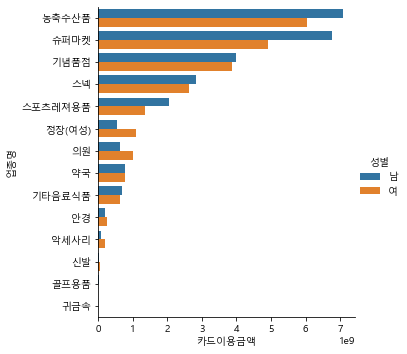

In [17]:
# 성별에 따른 각각의 업종 매출액
card_usage_amount_by_sex = data.groupby(['업종명','성별'])['카드이용금액'].sum()
cuabs = card_usage_amount_by_sex.to_frame(name="카드이용금액").reset_index().sort_values(by='카드이용금액',ascending=False)
# sns.set(rc={'figure.figsize':(80,10)})
display(cuabs)

g = sns.catplot(x='카드이용금액',y='업종명', hue='성별', data=cuabs, orient='h', kind='bar')

### 연령대별

In [18]:
age_grp = data['연령대별'].unique()
print(age_grp)

['50대' '40대' '30대' '20대']


### 카드이용금액

In [19]:
card_usage_amount = data['카드이용금액']
card_usage_amount.agg(['min','max'])

min       36100
max    64277700
Name: 카드이용금액, dtype: int64

#### 시간에 따른 업종별 카드이용금액
1. **농축수산품**
   - 10월, 4월에 가장 높은 매출을 보이고 있다.
   - 12월, 2월, 7월이 매출이 가장 좋지 않다.
2. **스포츠레저상품**
   - 특이사항 X
3. **골프 용품**
   - 11월, 12월 즈음이 가장 매출이 높다.
4. **악세서리**
   - 12월 전까지 감소 추세를 보이다가 12월에 매출이 크게 증가함을 확인할 수 있다.
5. **의원**
   - 12월까지 감소추세 후 1월 반등
   - 5,6월까지 감소 후 7월 즈음부터 매출 반등
6. **안경**
   - 7,8월에 매출이 크게 상승한다.
   - 선글라스의 영향 때문인가?
7. **정장(여성)**
   - 3,4,5월 즈음 매출이 상승세이다.
   - 10,11월을 기점으로 1월까지 쭉 감소추세이다.
   - 1,2월의 매출이 좋지 않다.
8. **기념품점**
   - 겨울에 가장 낮은 매출을 보이고 봄에 반등 후 여름에 정점을 찍는다. 이후 다시 감소추세로 넘어가는 패턴이 반복된다.
9. **기타음료식품**
   - 10월을 기점으로 겨울에는 감소 추세이다. 이후 매출이 반등하는 패턴을 보인다.
10. **슈퍼마켓**
    - 겨울이 여름에 비해 상대적으로 낮은 매출 양상을 띈다.
    - 겨울부터 8월까지 증가추세를 보이고 정점을 찍은 후 다시 감소 추세로 돌아선다.
11. **신발**
    - 2015년 4월 특이하게 매출이 매우 높았다.
    - 겨울에는 매출이 낮고, 날이 따듯해지면 다시 매출을 어느 정도 회복한다.
12. **약국**
    - 꾸준히 전반적으로 상승한다.
13. **스넥**
    - 겨울에 낮은 매출을 보이고 이후 상승 추세가 이어진다음 여름에 정점을 찍는다.
14. 귀금속
    - 매출 데이터가 매우 부족하다.

Text(0.5, 0.98, 'Card usage amount by industry')

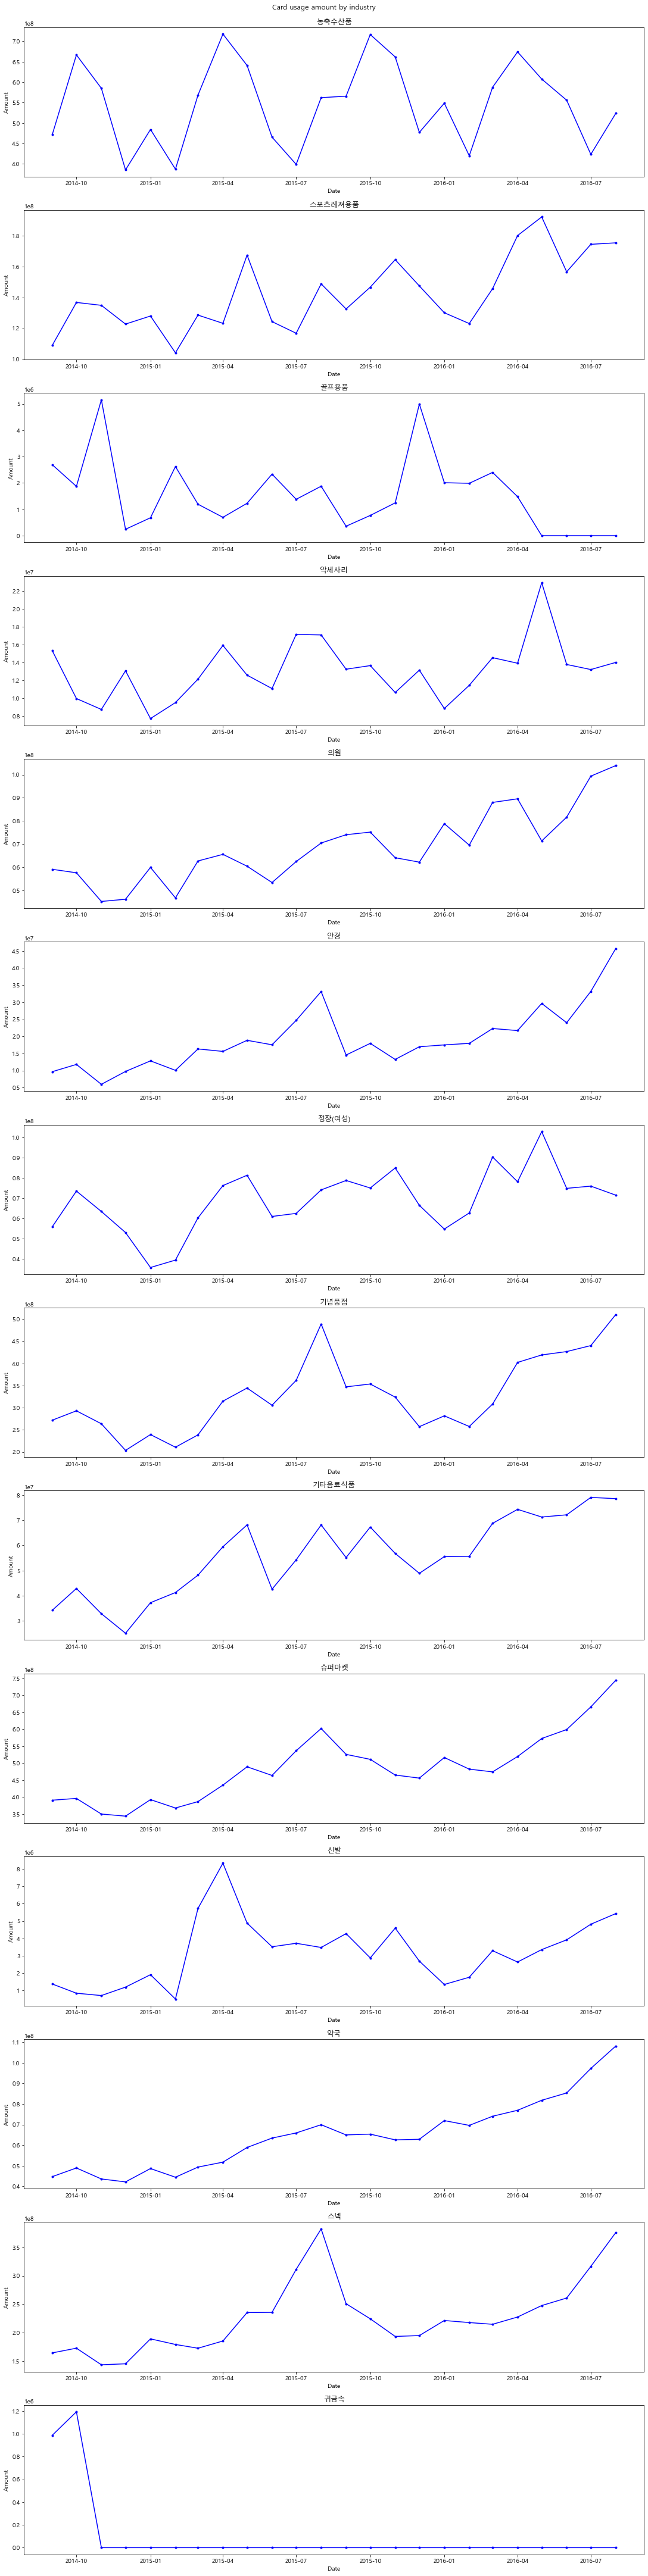

In [20]:
# 시간에 따른 업종별 카드이용금액
card_usage_amount_by_industry = data.groupby(['업종명','기준년월'])['카드이용금액'].sum()
dates = data['기준년월'].unique()
fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,60),constrained_layout=True)

# 업종중 특정날짜의 데이터가 없는 경우가 있다. 따라서 특정날짜의 data를 0으로 하여 추가한다.
for idx, industry in enumerate(upjong):
    result = card_usage_amount_by_industry.loc[(industry,dates)]
    date_by_industry = result.index.get_level_values('기준년월')
    for date in dates:
        if date not in date_by_industry:
            result[(industry,date)]=0          
           
    axes[idx].plot(dates,result,color='b',marker='.')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Amount')
    axes[idx].set_title(industry)

plt.suptitle('Card usage amount by industry')

#### 지역별로 소비된 업종 분포
1. **대륜동**
   - 농축수산품이 다른 업종에 비해 가장 많은 매출액을 기록하였다.
   - 대륜동에 다수의 귤농장이 분포해있는 것으로 보아 귤의 판매량이 많을 것으로 생각된다.
2. **남원읍**
   - 농축수산품, 스넥, 슈퍼마켓 기타음료식품 순으로 판매량이 많다.
   - 지도상으로 봤을 때 귤농장이 다수 분포함을 미루어보아 귤이 많이 판매될 것으로 예상된다.
   - 남원읍에는 펜션 등 숙박업소가 다수 분포해있다. 이를 미루어보아 스넥, 슈퍼마켓, 기타음료식품이 많이 판매되지 않았을까 생각한다.
   - 숙박업소와 위의 업종간의 관계는 추후 다시 확인해볼 필요가 있다.
3. **연동**
   - 슈퍼마켓, 스포츠레저용품, 스넥, 정장(여성)순으로 판매량이 많다.
   - 호텔, 게스트하우스 등 숙박업소가 다수 분포한 것으로 보아 슈퍼마켓과 스넥의 매출이 높을 것이라고 예상해본다.
   - 연동은 제주시의 번화가이므로 다양한 스포츠 브랜드들이 입점해있다.
   - 정장 브랜드들 또한 위와 같은 맥락이라고 생각한다.
4. **예래동**
   - 몇개의 귤농장이 존재한다. 하지만 이 때문에 농축수산품의 소비량이 높게 나오는 것인지는 모르겠다.
   - 주변에 민박, 호텔 등 숙박업소가 다수 존재하기 때문에 스넥, 기타음료식품, 슈퍼마켓 등의 매출이 높은 것으로 보인다.
   - 어떠한 이유로 스포츠레저용품의 소비가 많은지 모르겠다. 나중에 골프장, 승마장, 서핑과 연관관계가 있는지 확인해볼 필요가 있다.
5. **이도 2동**
   - 특별히 규모가 큰 마트가 있지도 않다. 그렇다고 숙박업소가 많은 것도 아니다. 왜 슈퍼마켓의 매출이 이토록 높은 것일까?
   - 농축수산품이 그 뒤를 잇는다. 청과상이 다수 분포함을 미루어보아 이 상점들에서 많은 소비가 발생한다고 예상된다.
6. **삼도 2동**
   - 스포츠 용품점이 매우 많은 것으로 보아 매출이 많은 원인을 알 수 있다.
   - 양복점이 매우 많은 것으로 보아 정장(여성)의 매출이 많은 원인을 알 수 있다.
   - 슈퍼마켓은 이마트가 큰 영향을 끼치지 않았을까 생각한다.
   - 청과 상점이 매우 많이 존재한다. 따라서 농축수산품의 많은 소비가 있었을 것이라고 생각된다.
7. **용담 2동**
   - 제주 공항이 위치하므로 많은 기념품들이 소비될 것으로 생각된다.
   - 근처에 귤농장이 있는지는 잘모르겠으나 공항에서 한라봉과 같은 과일들을 판매하지 않을까 생각된다.
8. **노형동**
   - 슈퍼마켓이 압도적으로 많은 매출을 기록하였으며 뒤이어 의원과 스넥이 많은 매출을 기록하였다.
   - 이마트, 롯데마트 등 대형마드들이 다수 분포하고 있으며 이외애도 다수의 마트들이 분포하고 있다. 따라서 슈퍼마켓의 매출이 가장 많은 것으로 생각된다.
   - 노형동에 많은 수의 의원들이 몰려있다. 이로 인해서 의원 업종의 매출이 높은 것으로 추정된다.
9. **애월읍**
   - 스넥, 슈퍼마켓, 농축수산품 순으로 높은 매출을 기록하였다.
   - 애월읍은 사람들이 많이 찾는 관광지이기 때문에 분식류를 판매하는 곳이 많을 확률이 높다. 지금껏 스넥 업종의 매출이 높았던 지역을 살펴보면 관광지인 경우가 많았다. 보통 관광지에 가면 닭꼬치, 아이스크림 등 여러가지 스넥류 상품들을 많이 판매한다. 따라서 이러한 노점상들은 지도에서 명확히 파악하기가 힘들어 일단은 스넥류 매출이 높은 이유의 가정으로만 남겨둔다.
   - 애월읍에는 게스트하우스, 펜션, 호텔 등 많은 수의 숙박업소가 위치해있다. 따라서 슈퍼마켓의 매출이 높은 것으로 추정된다.
   - 애월읍에는 다수의 귤농장이 분포해있다. 따라서 농축수산품의 매출이 높은 원인 중 하나라고 생각한다.
10. **성산읍**
    - 농축수산품, 슈퍼마켓, 기념품점, 스넥 순으로 높은 매출을 기록하였다.
    - 귤농장은 많지 않다. 하지만 바다를 끼고 있어 수산품의 소비가 많았을 것으로 추정한다.
    - 성산읍에는 호텔, 게스트 하우스, 펜션 등 다양한 숙박업소가 분포하고 있다. 따라서 슈퍼마켓의 매출이 높은 것으로 추정한다.
    - 성산일출봉, 섭지코지 등 매우 유명한 관광지가 위치하고 있다. 따라서 사람들이 이곳에서 많은 양의 기념품을 소비했을것으로 생각한다.
    - 위와 같은 관광지가 위치하고 있기 때문에 많은 양의 스넥류 상품들이 소비될 것이라고 생각한다.

Text(0.5, 0.98, 'Card usage amount by town')

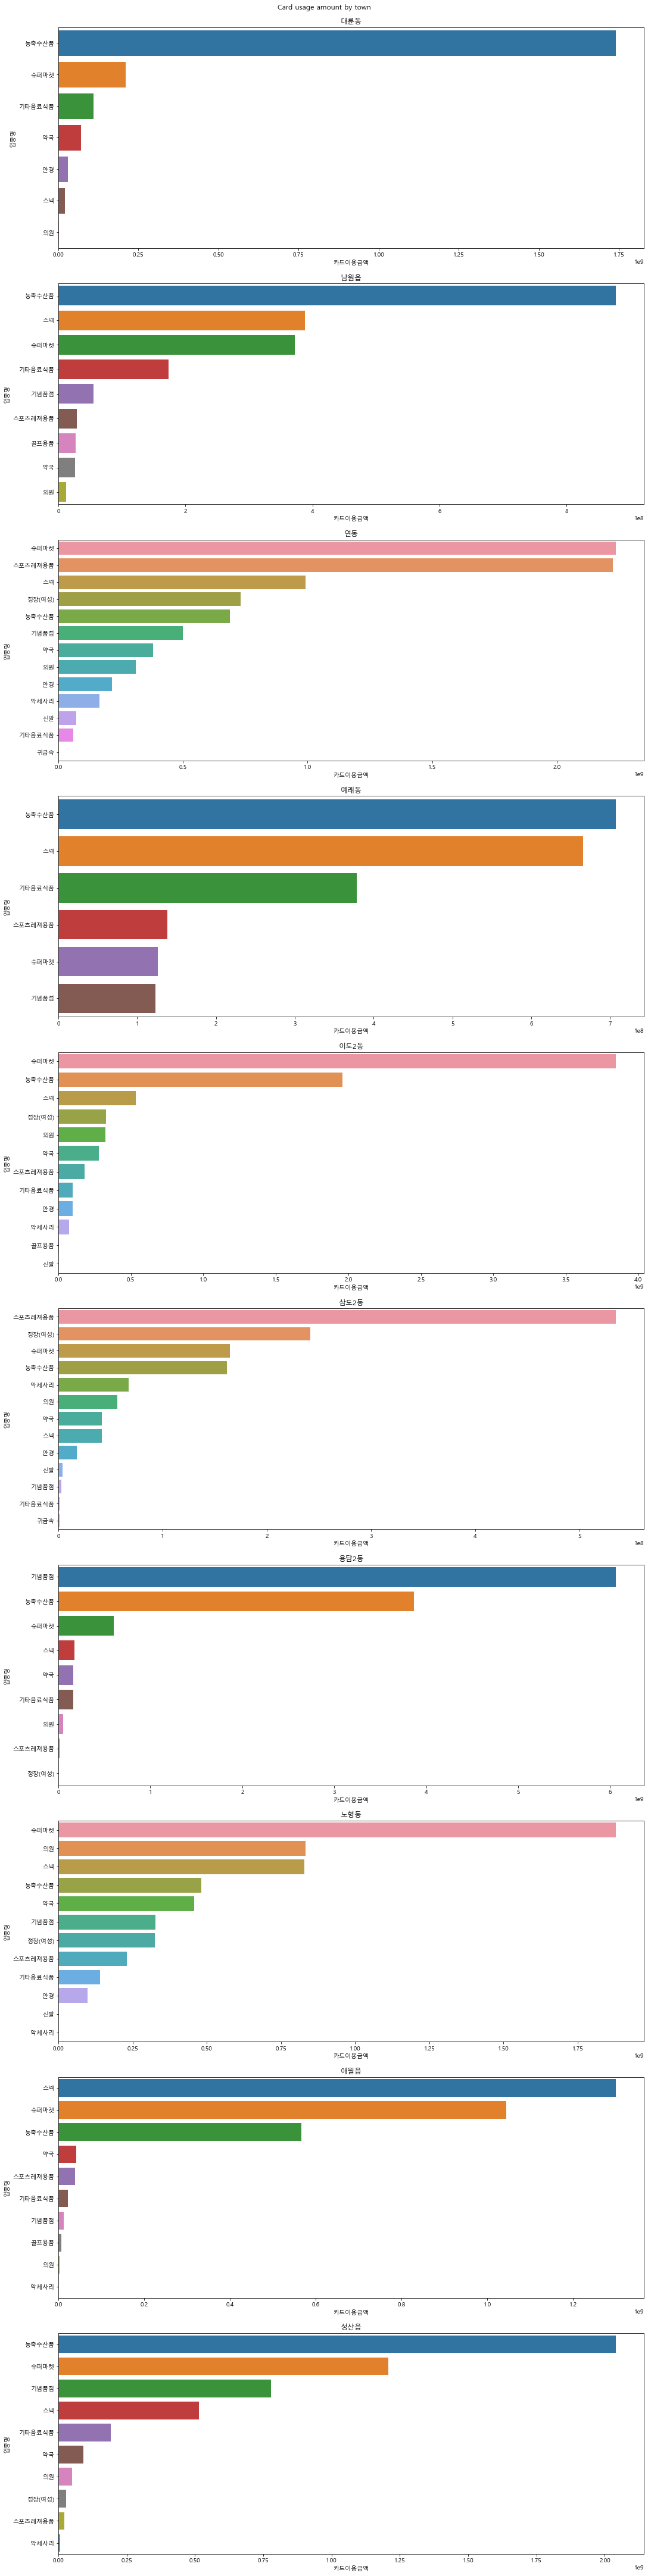

In [21]:
# 지역별로 소비된 업종 분포(카드사용금액 기준)
group_by_town_and_industry = data.groupby(['제주 중분류','업종명']).sum()
group_by_town_and_industry_df = group_by_town_and_industry.reset_index()

fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,60),constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='카드이용금액',y='업종명',data=group_by_town_and_industry_df[group_by_town_and_industry_df['제주 중분류']==town].sort_values(by='카드이용금액',ascending=False))
    axes[idx].set_title(town)

plt.suptitle('Card usage amount by town')

#### 지역별로 소비된 업종 분포(건당 이용 금액)
1. **대륜동**
   - 농축수산품이 건당이용금액이 가장 높다.
2. **남원읍**
   - 남원읍 역시 농축수산품이 건당이용금액이 가장 높았다.(카드이용금액 기준 기타음료식품, 슈퍼마켓, 스넥순)
3. **연동**
   - 장장(여성), 스포츠레저용품, 농축수산품, 악세서리 순으로 건당이용금액이 높았다.(카드이용금액 기준 슈퍼마켓, 스포츠레저상품, 스넥, 정장(여성)순)
   - 정장이 단가가 높다보니 건당 이용 금액이 높은 것 같다.
   - 악세서리도 비싸다보니 건당 이용 금액이 높은 것 같다.
   - 스넥의 경우 상품별 단가가 높지 않다보니 건당 이용 금액이 높지 않은 것 같다.
4. **예래동**
   - 농축수산품, 스포츠레저용품, 스넥 순으로 건당이용금액이 많았다.(카드이용금액 기준 농축수산품, 스넥, 기타음료식품 순)
   - 스넥과 기타음료식품은 매출이 높은 반면 건당이용금액이 작게 나왔는데 이는 상품별 단가가 낮기 때문이라고 생각한다.
5. **이도 2동**
   - 농축수산품, 정장(여성), 스포츠레저용품, 슈퍼마켓, 안경 등의 순으로 건당이용금액이 높았다.(카드이용금액 기준 슈퍼마켓, 농축수산품, 스넥, 정장순)
   - 정장이 단가가 비싸므로 건당이용금액이 높은 것으로 추정된다.
   - 스포츠레저용품과 안경 또한 상품별 단가가 높기 때문에 매출의 순위는 낮지만 건당이용금액 기준으로는 높은 순위를 기록한것으로 보인다.
   - 반면 스넥은 상품별 단가가 저렴하기 때문에 전체 매출은 높지만 건당이용금액에서는 낮은 순위를 기록한 것으로 보인다.
6. **삼도 2동**
   - 스포츠레저용품, 정장, 농축수산품, 악세서리, 의원 순으로 건당이용금액이 높다.(카드이용금액 기준 슈퍼마켓, 농축수산품, 스넥, 정장 순)
   - 슈퍼마켓의 경우 상품별 단가가 그리 높지 않기 때문에(물론 물품별로 세부적으로 들어가면 달라지겠지만 평균적으로 그렇다는 이야기이다.)매출면에서는 높은 순위를 기록하였지만 건당이용금액에서는 높은 순위를 기록하지 못한것으로 보인다.
7. **용담 2동**
   - 농축수산품, 기념품점, 기타음료식품, 슈퍼마켓 순으로 건당이용금액이 높다.(카드이용금액 기준 기념품점, 농축수산품, 슈퍼마켓 순)
   - 기타음료식품의 경우 슈퍼마켓에 비해 한번 거래할 때 많은 양의 상품을 구매하지 않기 때문에 높은 순위를 기록하지 못한것으로 추정된다.
   - 기념품도 각각의 상품이 높은 가격을 가지고 있지만 절대적인 거래 건수가 많지 않아 농축수산품에 밀린 것으로 보인다.
8. **노형동**
   - 정장, 스포츠레저용품, 농축수산품, 기념품점, 안경, 의원 순으로 건당이용금액이 높다.(카드이용금액 기준 슈퍼마켓, 의원, 스넥, 농축수산품, 약국 순)
   - 정장은 매우 비싸므로 높은 건당이용금액 순위를 보이고 있다.
   - 스포츠레저용품 또한 상품 당 단가가 비싸기 때문에 높은 건당이용금액을 보이고 있다.
   - 기념품도 저렴한 가격은 아니기에 높은 건당이용금액을 보이는 것으로 추정된다.(안경도 같은 맥락)
   - 의원도 한번 진료 시 꽤 많은 돈이 나가가에 높은 건당이용금액을 보이고 있다.
   - 슈퍼마켓, 스넥은 물품들의 가격이 그다지 높은 상품들이 아니기에 한꺼번에 많이 사지 않는 이상 높은 건당이용금액을 보일수가 없다. 따라서 낮은 건당이용금액 순위를 보이는 것으로 추정된다.
   - 일반적으로 약국에서 많은 양의 약을 구매하는 일은 매우 드물다. 따라서 높은 건당이용금액을 보여주지 않은 것으로 생각한다.
   - 의원의 매출과 약국의 매출은 유의미한 상관관계가 있을 것으로 생각한다.
9. **애월읍**
   - 농축수산품, 스넥, 슈퍼마켓, 스포츠레저용품 순으로 건당이용금액이 높았다.(카드이용금액 기준 스넥, 슈퍼마켓, 농축수산품 순)
   - 위의 결과를 확인해보면 건당이용금액에서 스포츠레저용품이 높은 순위를 기록했음을 확인할 수 있다. 하지만 매출을 확인해보면 낮은 순위에 위치해있는데 일단 절대적으로 낮은 거래량으로 인해서 낮은 매출 순위를 기록한 것으로 보인다.
   - 스넥과 슈퍼마켓에 비해 농축수산품이 물품 당 높은 가격대를 형성하고 있기 때문에 건당이용금액에서 더 높은 순위를 기록한 것으로 보인다.
10. **성산읍**
    - 농축수산품, 기념품점, 스넥, 기타음료식품, 슈퍼마켓 순으로 높은 건당이용금액을 보이고 있다.(카드이용금액 기준 농축수산품, 슈퍼마켓, 기념품점, 스넥 순)
    - 기념품점의 경우 물품들의 가격이 꽤 나가기 때문에 건당이용금액이 높은 것으로 추정된다.
    - 기타음료식품의 경우 상품의 가격이 비교적 저렴하기 때문에 높은 매출을 기록하여도 낮은 건당이용금액 순위를 보이는 것으로 생각한다.

Text(0.5, 0.98, 'Number of card usage by town')

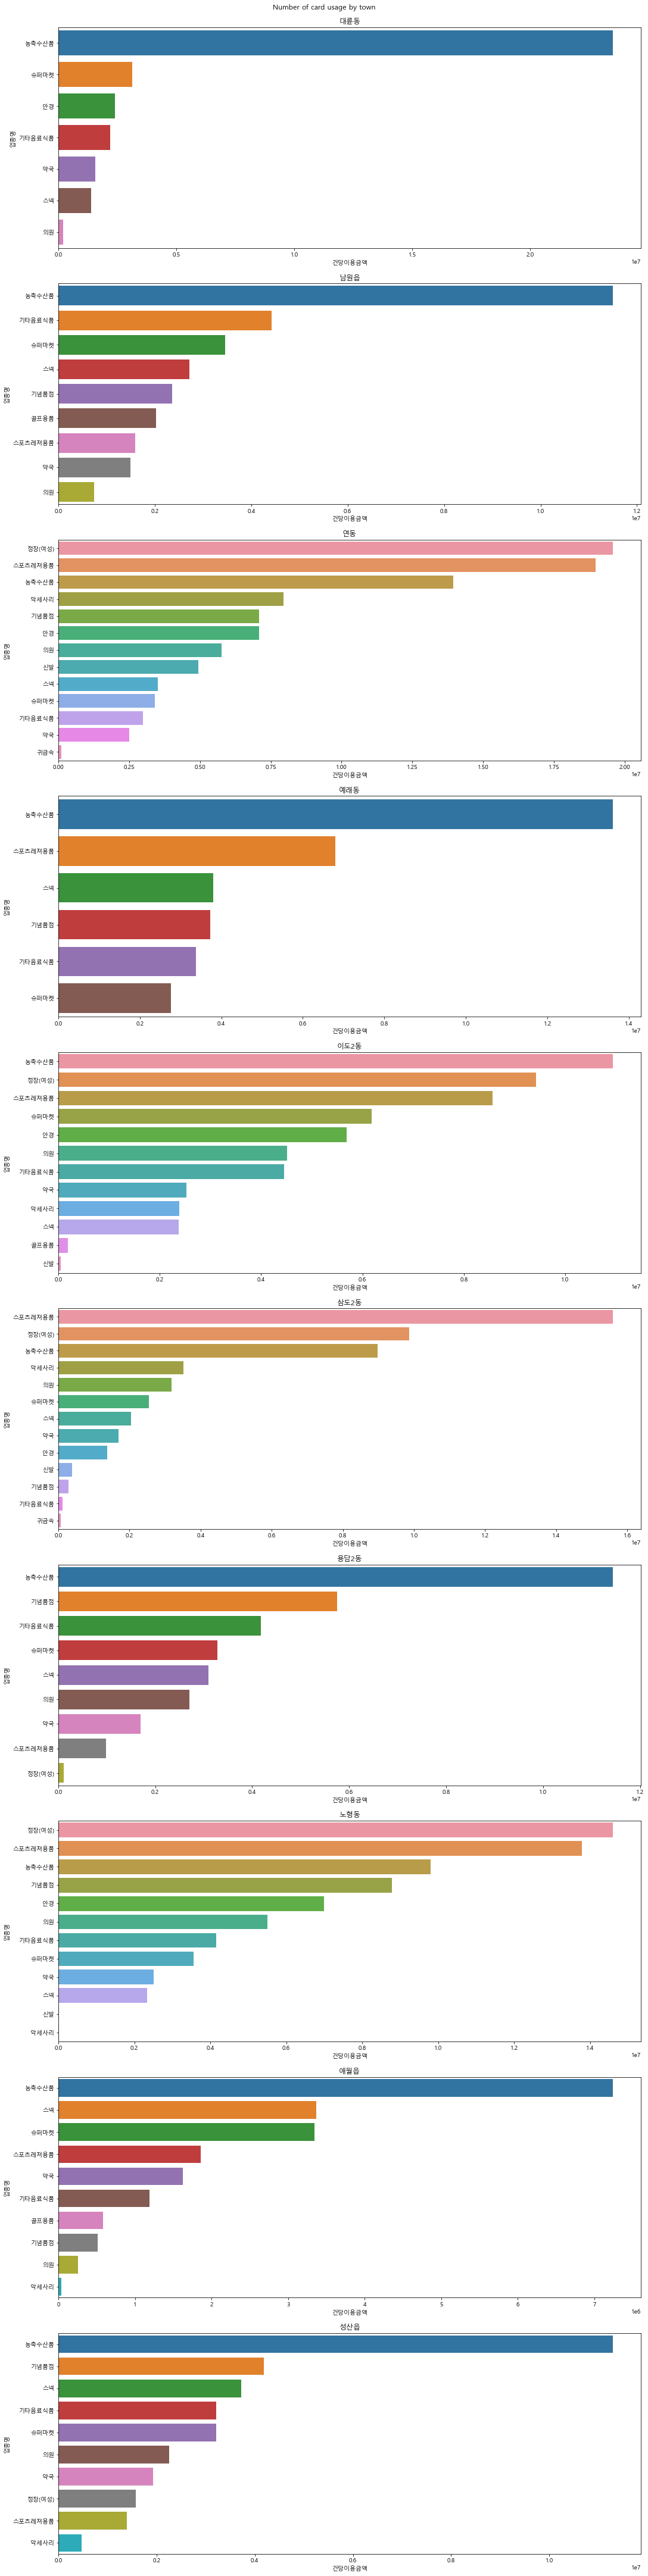

In [22]:
# 지역별로 소비된 업종 분포(카드이용건수 기준)
fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,60),constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='건당이용금액',y='업종명',data=group_by_town_and_industry_df[group_by_town_and_industry_df['제주 중분류']==town].sort_values(by='건당이용금액',ascending=False))
    axes[idx].set_title(town)

plt.suptitle('Number of card usage by town')

#### 지역별로 소비된 연령대
1. **대륜동**
   - 30대,40대,20대,50대 순으로 인원 수가 더 많았다.
2. **남원읍**
   - 50대,40대,30대,20대 순으로 인원 수가 많았다.
   - 농축수산품의 매출이 가장 높았는데 이는 남원읍에서 소비한 연령층이 높다는 것과 유의미한 상관관계가 있을 것이라고 생각한다.
3. **연동**
   - 30대,20대,40대,50대 순으로 인원 수가 더 많았다.
   - 슈퍼마켓, 스포츠레저용품, 스넥 순으로 매출이 높았었는데 연령층이 젊은 것과 관련하여 유의미한 상관관계가 있을 것이라고 생각한다.
4. **예래동**
   - 40대,50대,30대,20대 순으로 소비 인원수가 많았다.
5. **이도 2동**
   - 30대,20대,40대,50대 순으로 소비 인원수가 많다.
6. **삼도 2동**
   - 30대,40대,20대,50대 순으로 소비 인원수가 많았다.
7. **용담 2동**
   - 30대,40대,20대,50대 순으로 소비 인원수가 많았다.
   - 전연령대에서 인원수가 크게 차이나지 않았다.
8. **노형동**
   - 30대,40대,20대,50대 순으로 소비 인원수가 많았다.
9. **애월읍**
   - 30대,40대,50대,20대 순으로 소비 인원수가 많았다.
10. **성산읍**
    - 30대,40대,20대,50대 순으로 소비 인원수가 많았따.

Text(0.5, 0.98, 'Age group by town')

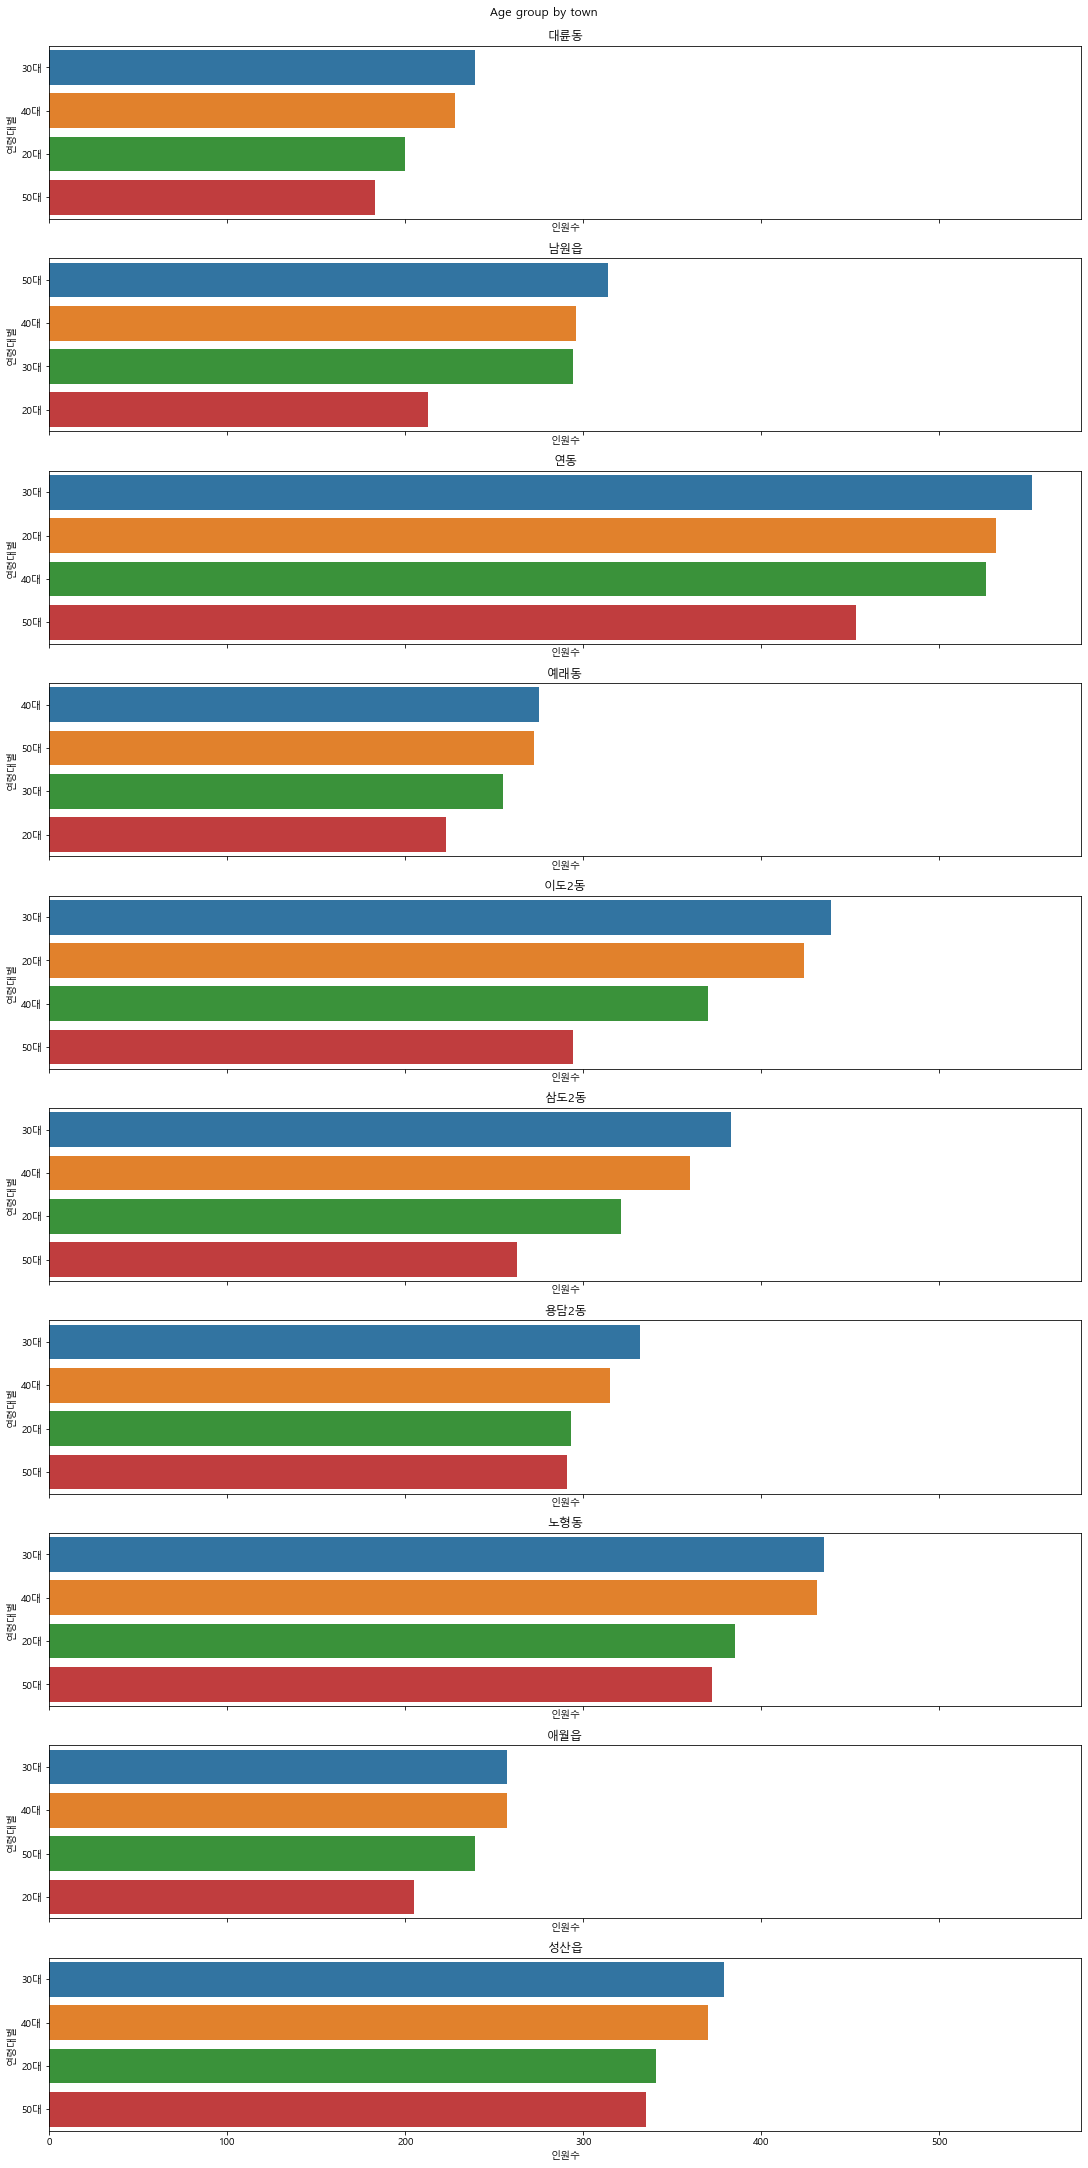

In [23]:
# 지역별로 소비된 연령대
age_grp_by_town = data.groupby(['제주 중분류','연령대별']).size()
age_grp_by_town_df = age_grp_by_town.to_frame('인원수').reset_index()
fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,30),sharex=True,constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='인원수',y='연령대별',data=age_grp_by_town_df[age_grp_by_town_df['제주 중분류']==town].sort_values(by='인원수',ascending=False))
    axes[idx].set_title(town)

plt.suptitle('Age group by town')

Text(0.5, 1.0, '지역별 카드 이용 건수')

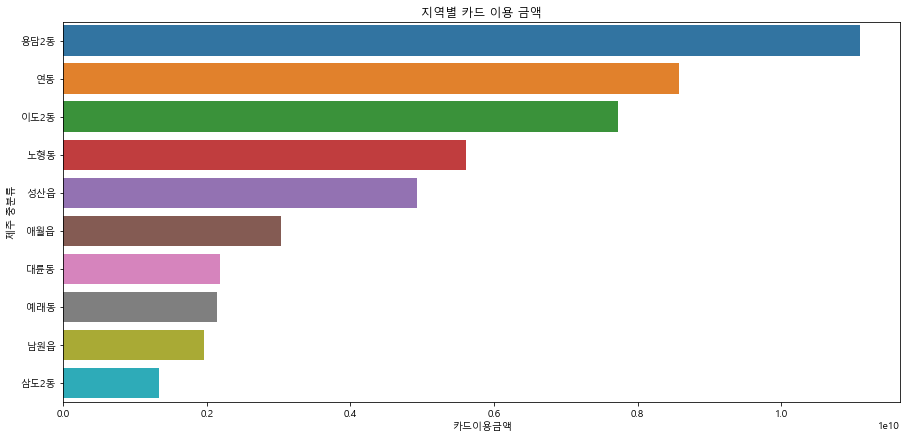

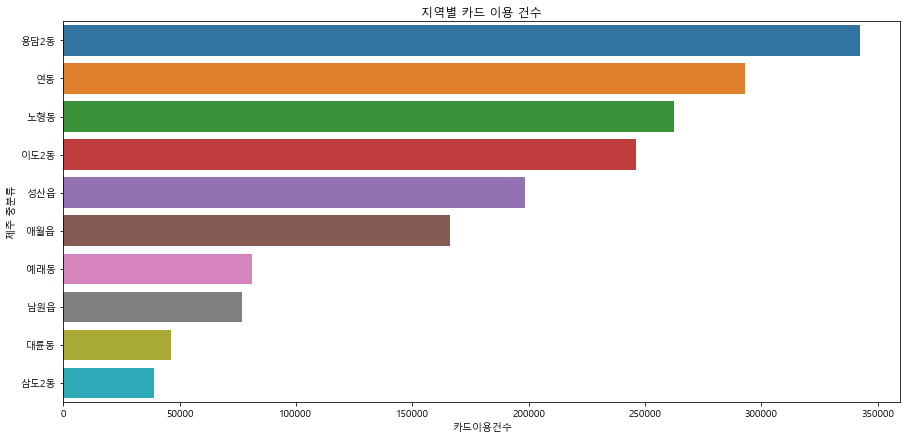

In [24]:
# 지역별 카드 이용 금액
card_usage_amount_town = data.groupby('제주 중분류')['카드이용금액'].sum()
card_usage_amount_town_df = card_usage_amount_town.to_frame('카드이용금액').reset_index()
plt.figure(figsize=(15,7))
ax= sns.barplot(x='카드이용금액',y='제주 중분류',data=card_usage_amount_town_df.sort_values(by='카드이용금액',ascending=False))
ax.set_title('지역별 카드 이용 금액')

# 지역별 카드 이용 건수
number_of_card_usage_by_town = data.groupby('제주 중분류')['카드이용건수'].sum()
number_of_card_usage_by_town_df = number_of_card_usage_by_town.to_frame('카드이용건수').reset_index()
plt.figure(figsize=(15,7))
ax= sns.barplot(x='카드이용건수',y='제주 중분류',data=number_of_card_usage_by_town_df.sort_values(by='카드이용건수',ascending=False))
ax.set_title('지역별 카드 이용 건수')

#### 업종별로 연령대별 인원수
1. 농축수산품
   - 40대,30대,50대,20대 순으로 소비 인원수가 많았다.
   - 인원수가 많은 차이가 나지는 않는다.
2. 스포츠레저상품
   - 40대,50대,30대,20대 순으로 소비 인원수가 많다.
   - 20대의 경우 128명으로 가장적은숫자를 기록하였다.(30대에 비해 절반수준이다.)
3. 골프용품
   - 50대,40대 순으로 인원수가 많았으며 30대,20대는 없다.
4. 악세서리
   - 30대,20대,40대,50대 순으로 소비 인원수가 많다.
   - 50대는 40명으로 40대의 절반도 안된다.
5. 의원
   - 40대,30대,50대,20대 순으로 소비 인원수가 많다.
   - 20대는 나머지 연령층보다 상대적으로 인원수가 적다.
6. 안경
   - 30대,20대,40대,50대 순으로 소비 인원수가 많다.
   - 40대,50대는 각각 30대 인원의 절반, 절반의 절반 인원수를 갖는다.
7. 정장(여성)
   - 30대,40대,20대,50대 순으로 소비 인원수가 많다.
   - 30대,40대,20대는 큰 차이가 없으나 50대는 큰 격차(20대에 비해 60명 정도)를 보이고 있다.
8. 기념품점
   - 30대,40대,50대,20대 순으로 소비 인원수가 많다.
   - 50대와 20대가 30대와 40대에 비해 조금 적은 인원수이지만 큰 차이는 아니다.
9. 기타음료식품
   - 30대,40대,20대,50대 순으로 소비 인원수가 많다.
   - 50대는 다른 연령층에 비해 약간 큰 격차가 있다.(20대에 비해 70명 정도 차이가 난다.)
10. 슈퍼마켓
    - 전연령대가 비슷한 인원수를 가진다.
11. 신발
    - 절대적인 인원수가 적다.
12. 약국
    - 30대,40대,50대,20대 순으로 소비 인원수가 많다.
    - 20대가 다른 연령층에 비해 약간 큰 격차를 보이고 있으며 의원의 이용인원수에서도 꼴지인 것과 연관이 있다고 생각한다.
13. 스넥
    - 30대,40대,20대,50대 순으로 소비 인원수가 많다.
    - 50대가 20대에 비해 다소 큰 격차(40명 정도)를 보이고 있으나 절대적인 소비인원은 적지 않다.
14. 귀금속
    - 절대적인 인원수가 부족하다.

,업종명,연령대별,인원수
0,골프용품,40대,12
1,골프용품,50대,27
2,귀금속,20대,1
3,귀금속,30대,1
4,귀금속,40대,1
5,기념품점,20대,234
6,기념품점,30대,274
7,기념품점,40대,271
8,기념품점,50대,238
9,기타음료식품,20대,378


Text(0.5, 0.98, 'Age group by industry')

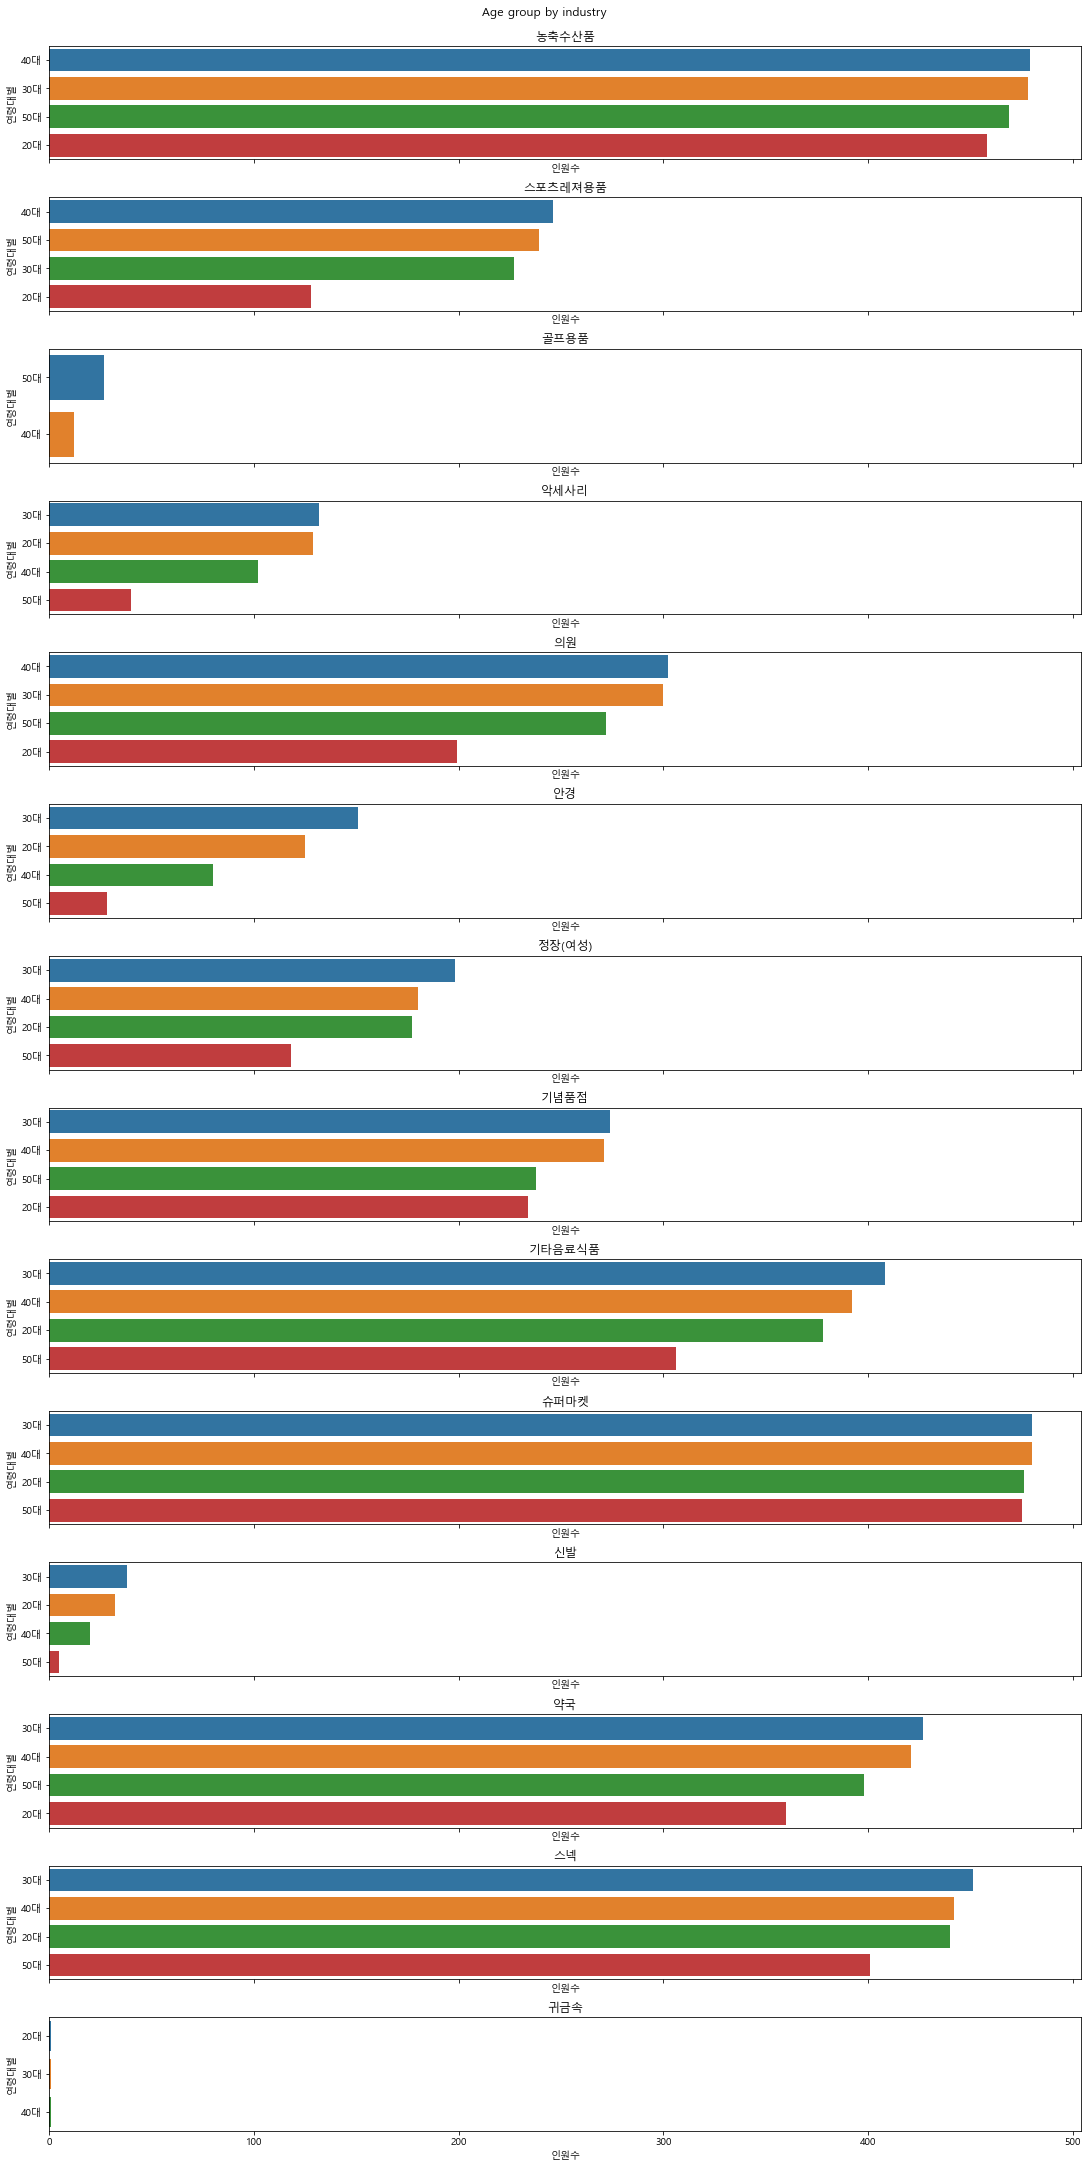

In [25]:
#업종별로 연령대별 인원수
age_grp_by_industry = data.groupby(['업종명','연령대별']).size()
age_grp_by_industry_df = age_grp_by_industry.to_frame('인원수').reset_index()
display(age_grp_by_industry_df)

fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,30),sharex=True,constrained_layout=True)

for idx, industry in enumerate(upjong):
    sns.barplot(ax=axes[idx],x='인원수',y='연령대별',data=age_grp_by_industry_df[age_grp_by_industry_df['업종명']==industry].sort_values(by='인원수',ascending=False))
    axes[idx].set_title(industry)

plt.suptitle('Age group by industry')

### Feature Engineering
- 업종들 중에서 매출의 큰 비중을 차지 않는 것(또는 매출 정보가 부족한 업종)들은 삭제하도록 하자.
- 주어진 기간 동안 총 매출이 10억 미만인 업종은 삭제하자.


In [32]:
card_usage_sum = data.groupby('업종명')['카드이용금액'].sum()
card_usage_sum.sort_values(ascending=False)

업종명
농축수산품      13092560386
슈퍼마켓       11690570213
기념품점        7864854995
스넥          5461163557
스포츠레져용품     3413438318
정장(여성)      1652690560
의원          1646625884
약국          1552649845
기타음료식품      1338100496
안경           460747530
악세사리         313149990
신발            77235600
골프용품          37213800
귀금속            2180100
Name: 카드이용금액, dtype: int64

#### 날짜
- 날짜를 year, month 단위로 분해하여 column을 추가하자. 
- day의 경우 모두 1이므로 추가하지 않는다.

In [33]:
data['year'] = data['기준년월'].dt.year.astype(str)
data['month'] = data['기준년월'].dt.month.astype(str)

#### Encoding
- Categorical 변수들에 대해서 one-hot encoding을 적용한다.

In [34]:
data_df = data.drop(['카드이용건수','건당이용금액'],axis=1,inplace=False)
drop_row = card_usage_sum.loc[card_usage_sum < 1000000000].index
for row in drop_row:
    data_df = data_df[data_df['업종명']!=row]
data_df['업종명'].unique()

array(['농축수산품', '스포츠레져용품', '의원', '정장(여성)', '기념품점', '기타음료식품', '슈퍼마켓', '약국',
       '스넥'], dtype=object)

In [35]:
# test-set과 train-set 분리
local_train = data_df[data_df['기준년월'] <= '2016-03-01'].reset_index(drop=True)
local_test = data_df[data_df['기준년월'] > '2016-03-01'].reset_index(drop=True)

local_train.drop('기준년월',axis=1,inplace=True)
local_test.drop('기준년월',axis=1,inplace=True)

display(local_train.shape)
display(local_test.shape)
# 전체 data중에서 약 22%가 test set으로 사용된다.

(9509, 8)

(2713, 8)

##### One-Hot Encoding

In [30]:
# Categorical variable feature들에 대해서 one-hot encoding 적용.

"""
1.먼저 data에서 필요없는 column을 제거한다
2. one-hot encoding을 적용한다.
3. test & train set을 분리한다. 
   -> 이 과정에서 시간순서로 분리하는데 문제가 발생한다.
   -> year, month로 one-hot encoding을 진행하였기 떄문에 시간순서로 test, train set을 나누기가 어렵다.

Q. 만약 둘을 먼저 나누고 one-hot encoding을 적용하려면 어떻게 해야할까?
"""

# get_dummies 함수를 이용해서 one-hot encoding을 진행한다.
# print('get_dummies 전의 특성 : \n',list(local_train.columns))
local_train = pd.get_dummies(local_train).reset_index(drop=True)
local_test = pd.get_dummies(local_test).reset_index(drop=True)
# print('get_dummies 후의 특성 : \n',list(local_train.columns))
# print('get_dummies 후의 특성 : \n',list(local_test.columns))
local_train_set = set(local_train.columns)
local_test_set = set(local_test.columns)
a_b = local_train_set - local_test_set
b_a = local_test_set - local_train_set

for col in a_b:
    local_test[col] = 0
for col in b_a:
    local_train[col] = 0
    
display(len(local_test.columns))
display(len(local_train.columns))
display(local_test.head())
display(local_train.head())

43

43

,카드이용금액,제주 대분류_서귀포시,제주 대분류_제주시,제주 중분류_남원읍,제주 중분류_노형동,제주 중분류_대륜동,제주 중분류_삼도2동,제주 중분류_성산읍,제주 중분류_애월읍,제주 중분류_연동,제주 중분류_예래동,제주 중분류_용담2동,제주 중분류_이도2동,업종명_기념품점,업종명_기타음료식품,업종명_농축수산품,업종명_슈퍼마켓,업종명_스넥,업종명_스포츠레져용품,업종명_약국,업종명_의원,업종명_정장(여성),성별_남,성별_여,연령대별_20대,연령대별_30대,연령대별_40대,연령대별_50대,year_2016,month_4,month_5,month_6,month_7,month_8,month_9,month_1,month_10,year_2014,month_2,month_11,month_3,year_2015,month_12
0,6224400,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8083050,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5419000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29398900,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26477500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


,카드이용금액,제주 대분류_서귀포시,제주 대분류_제주시,제주 중분류_남원읍,제주 중분류_노형동,제주 중분류_대륜동,제주 중분류_삼도2동,제주 중분류_성산읍,제주 중분류_애월읍,제주 중분류_연동,제주 중분류_예래동,제주 중분류_용담2동,제주 중분류_이도2동,업종명_기념품점,업종명_기타음료식품,업종명_농축수산품,업종명_슈퍼마켓,업종명_스넥,업종명_스포츠레져용품,업종명_약국,업종명_의원,업종명_정장(여성),성별_남,성별_여,연령대별_20대,연령대별_30대,연령대별_40대,연령대별_50대,year_2014,year_2015,year_2016,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,14434000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,15119000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7609500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7092500,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,9098500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


##### Label Encoding

In [36]:
lbl = LabelEncoder()

cat_cols = ['제주 대분류','제주 중분류','업종명','성별','연령대별','year','month']
for col in tqdm_notebook( cat_cols ):  
    temp_df = pd.concat([local_train[[col]], local_test[[col]]] , axis=0)
    lbl.fit(temp_df[col])
    
    local_train[col] = lbl.transform(local_train[col])
    local_test[col] = lbl.transform(local_test[col])
    
    print("인코딩 클래스 : ",lbl.classes_)

  0%|          | 0/7 [00:00<?, ?it/s]

인코딩 클래스 :  ['서귀포시' '제주시']
인코딩 클래스 :  ['남원읍' '노형동' '대륜동' '삼도2동' '성산읍' '애월읍' '연동' '예래동' '용담2동' '이도2동']
인코딩 클래스 :  ['기념품점' '기타음료식품' '농축수산품' '슈퍼마켓' '스넥' '스포츠레져용품' '약국' '의원' '정장(여성)']
인코딩 클래스 :  ['남' '여']
인코딩 클래스 :  ['20대' '30대' '40대' '50대']
인코딩 클래스 :  ['2014' '2015' '2016']
인코딩 클래스 :  ['1' '10' '11' '12' '2' '3' '4' '5' '6' '7' '8' '9']


## 3. Modeling

### Linear Regresstion

In [37]:
X_train, y_train = local_train.drop(['카드이용금액'],axis=1,inplace=False), local_train['카드이용금액']
X_test, y_test = local_test.drop(['카드이용금액'],axis=1,inplace=False), local_test['카드이용금액']

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

lr = LinearRegression()
lr.fit(X_train, y_train_log)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test_log, y_preds)
rmse = sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test_log,y_preds)))
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

MSE : 1.678, RMSE : 1.295
Variance score : 0.108636
절편 값: 13.88872228639241
회귀 계수값: [ 0.5  0.1 -0.1 -0.   0.1  0.1  0. ]


In [38]:
def get_top_error_data(y_test,pred,n_tops=5):
    result_df = pd.DataFrame(y_test.values,columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test_log,y_preds,n_tops=5)

      real_count  predicted_count      diff
1616   10.874285             15.0  4.125715
1071   11.167628             15.0  3.832372
1078   11.258046             15.0  3.741954
518    11.321172             15.0  3.678828
2661   11.428467             15.0  3.571533



### Target Variable의 분포 살펴보기

<Figure size 1080x504 with 0 Axes>

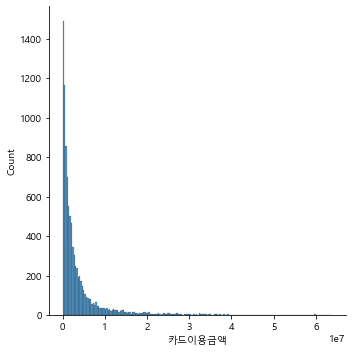

In [39]:
# target variable의 분포
ax = plt.figure(figsize=(15,7))
sns.displot(ax=ax,data=y_train)

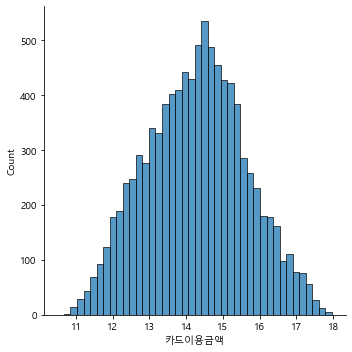

In [40]:
# log변환 후 target variable의 분포
y_log_transform = np.log1p(y_train)
sns.displot(y_log_transform)

In [41]:
# Light GBM 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993  
lgbm_param = {'n_estimators':200,
              'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,   
              'learning_rate':0.1,
              'tree_learner': 'serial',
              'early_stopping_rounds':100,
              'subsample_freq': 1,
              'num_leaves': 40,
              'verbose':-1,
              'seed' : SEED
            }

# XGBoost 모델에 쓰일 parameter 정의
xgb_params={ 'booster':'gbtree',
         'silent':1,
         'max_depth':6,
         'early_stopping_rounds':50,
         'eta':0.3,
         'eval_metric':'rmse',
         'verbosity':0
}

In [42]:
# target label을 log 변환을 취해준 후 모델을 생성

# 각 모델에 대한 oof 정의
ridge_oof_train = np.zeros((y_train.shape[0]))
lasso_oof_train = np.zeros((y_train.shape[0]))
dt_oof_train = np.zeros((y_train.shape[0]))
rf_oof_train = np.zeros((y_train.shape[0]))
lgbm_oof_train = np.zeros((y_train.shape[0]))
xgb_oof_train = np.zeros((y_train.shape[0]))
lgbm_oof_train_not_log = np.zeros((y_train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# target variable에 log변환을 취해준다.
y_train_log = np.log1p(y_train)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train_log ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train.iloc[trn_ind], y_train_log[trn_ind]
    X_valid , y_valid = X_train.iloc[val_ind], y_train_log[val_ind]
    
    # (1) Ridge
    print("---TRAINING RIDGE---")
    ridge = Ridge(random_state = 1993)
    
    ridge.fit(X_train_f, y_train_f)
    
    ridge_valid_pred = ridge.predict(X_valid)
    ridge_oof_train[val_ind] = ridge_valid_pred
#     np.expm1(ridge_valid_pred)
    
    # (2) Lasso
    print("---TRAINING LASSO---")
    lasso = Lasso(random_state = 1993)
    
    lasso.fit(X_train_f, y_train_f)
    
    lasso_valid_pred = lasso.predict(X_valid)
    lasso_oof_train[val_ind] = lasso_valid_pred
#     np.expm1(lasso_valid_pred)
    
    # (3) Decision Tree
    print("---TRAINING DECISION TREE---")
    dt = DecisionTreeRegressor(random_state=231)
    
    dt.fit(X_train_f, y_train_f)
    
    dt_valid_pred = dt.predict(X_valid)
    dt_oof_train[val_ind] = dt_valid_pred
#     np.expm1(dt_valid_pred)
    
    
    # (4) Random Forest
    print("---TRAINING RANDOM FOREST---")
    rf = RandomForestRegressor(random_state=231, n_estimators=20 )
    
    rf.fit(X_train_f, y_train_f)
    
    rf_valid_pred = rf.predict(X_valid)
    rf_oof_train[val_ind] = rf_valid_pred
#     np.expm1(rf_valid_pred)
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train_f, y_train_f)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    lgbm_model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 0)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = lgbm_model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_train_not_log[val_ind] = np.expm1(lgbm_valid_pred)
    
    # (6) XGBoost
    print("---TRAINING XGBOOST--")
    dtrain = xgb.DMatrix(X_train_f,y_train_f)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    # model 정의 & 학습
    xgb_model = xgb.train(xgb_params,dtrain, NUM_BOOST_ROUND,
                     evals=[(dtrain,'train'),(dvalid,'valid')],
                        early_stopping_rounds=100,
                         verbose_eval=0)
    
    xgb_valid_pred = xgb_model.predict(dvalid)
    
    xgb_oof_train[val_ind] = xgb_valid_pred
    print('='*80)
    
print(f"<Ridge> OVERALL RMSE         : {sqrt( mean_squared_error( y_train_log, ridge_oof_train ) )}")
print(f"<Lasso> OVERALL RMSE         : {sqrt( mean_squared_error( y_train_log, lasso_oof_train ) )}")
print(f"<Decision-Tree> OVERALL RMSE : {sqrt( mean_squared_error( y_train_log, dt_oof_train ) )}")
print(f"<Random-Forest> OVERALL RMSE : {sqrt( mean_squared_error( y_train_log, rf_oof_train ) )}")
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( y_train_log, lgbm_oof_train ) )}")
print(f"<XGBoost> OVERALL RMSE     : {sqrt( mean_squared_error( y_train_log, xgb_oof_train ) )}")
# print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( y_train, lgbm_oof_train_not_log ) )}")

0it [00:00, ?it/s]

---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
---TRAINING XGBOOST--
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
---TRAINING XGBOOST--
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
---TRAINING XGBOOST--
---TRAINING RIDGE---
---TRAINING LASSO---
---TRAINING DECISION TREE---
---TRAINING RANDOM FOREST---
---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
---TRAINING XGBOOST--
---TRAINING RIDG

### LightGBM

In [43]:
oof_train = np.zeros((local_train.shape[0],))
oof_test = np.zeros((local_test.shape[0],))

cv_list=[]

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# target variable에 log변환을 취해준다.
y_train_log = np.log1p(y_train)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train_log ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train.iloc[trn_ind], y_train_log[trn_ind]
    X_valid , y_valid = X_train.iloc[val_ind], y_train_log[val_ind]
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train_f, y_train_f)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    lgbm_model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','test'), 
                       verbose_eval= 30)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = lgbm_model.predict(X_valid)
    lgbm_test_pred = lgbm_model.predict(X_test)    
    
    cv_list.append(sqrt(mean_squared_error(y_valid,lgbm_valid_pred)))
    
    oof_train[val_ind] = lgbm_valid_pred
    oof_test += lgbm_test_pred/n_splits
    
    print('='*80)
    
print(f"<LOCAL_TRAIN> OVERALL RMSE : {sqrt( mean_squared_error( y_train_log, oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {sqrt( mean_squared_error( np.log1p(y_test), oof_test ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
Training until validation scores don't improve for 100 rounds
[30]	train's rmse: 0.53331	test's rmse: 0.534321
[60]	train's rmse: 0.432838	test's rmse: 0.44398
[90]	train's rmse: 0.392966	test's rmse: 0.414422
[120]	train's rmse: 0.370374	test's rmse: 0.398396
[150]	train's rmse: 0.353506	test's rmse: 0.389145
[180]	train's rmse: 0.340006	test's rmse: 0.382343
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.333078	test's rmse: 0.37997
---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
Training until validation scores don't improve for 100 rounds
[30]	train's rmse: 0.534904	test's rmse: 0.535953
[60]	train's rmse: 0.430474	test's rmse: 0.442684
[90]	train's rmse: 0.389332	test's rmse: 0.410587
[120]	train's rmse: 0.367093	test's rmse: 0.397973
[150]	train's rmse: 0.351918

#### Feature들 간의 상관관계 분석

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

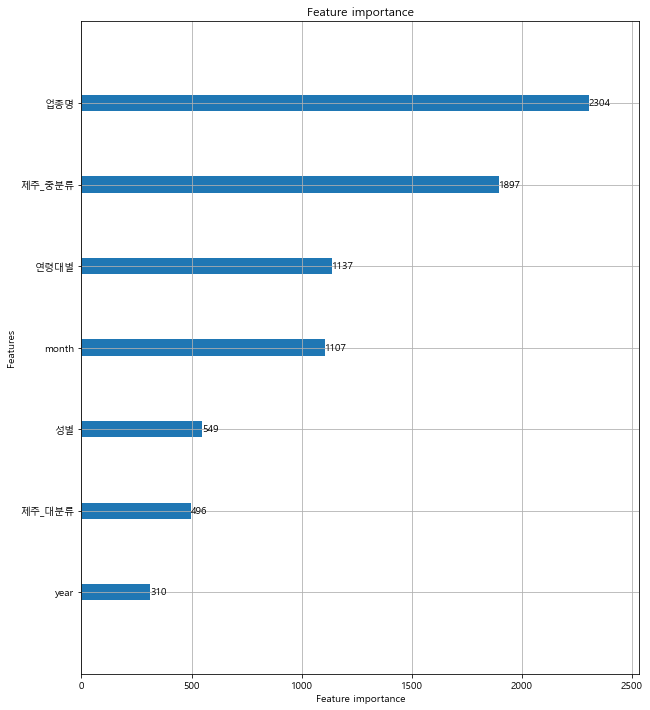

In [44]:
fig, ax = plt.subplots(figsize=(10,12))
lgbm.plot_importance(lgbm_model,ax=ax)

In [45]:
import skimage
import shap

explainer = shap.TreeExplainer(lgbm_model) # Tree model shap value 확인 객체 지정
shap_values_test = explainer.shap_values(X_test)
shap_values_train = explainer.shap_values(X_train)

# 특정 데이터 하나 & 전체 데이터에 대해, shapley value를 1차원 평면에 정렬해서 보여준다.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_test[20,:],X_test.iloc[20,:])

**1. 업종명**
   - 값이 클수록 model에 부정적인 영향을 끼친다.(스포츠레저용품, 약국, 의원, 정장(여성))
   - 값이 작을수록 model에 긍정적인 영향을 끼친다.(기념품점, 기타음료식품, 농축 수산품, 스넥) 
**2. 제주 중분류**
   - 값이 클수록 model에 긍정적인 영향을 끼친다.(애월읍, 연동, 예래동, 용담 2동, 이도 2동)
   - 값이 작을수록 model에 부젖ㅇ적인 영향을 끼친다.(남원읍, 노형동, 대륜동, 삼도 2동, 성산읍)
**3. 연령대별**
   - 값이 작을수록 부정적인 영향을 끼친다.
   - 값이 클수록 긍정적인 영향을 끼치긴한데 영향폭이 크지는 않다.
**4. 제주 대분류**
   - 값이 클수록 긍적적인 영향을 끼치지만 영향폭이 크지는 않다.
   - 값이 작을수록 model에 부정적인 영향을 끼친다.
**5. year**
   - 모두 긍정적인 영향을 끼치지만 영향폭이 크지는 않다.
**6. 성별**
   - 값이 클수록 model에 부정적인 영향을 끼치는 경향이 있다.
   - 그러나 영향폭이 크지는 않다.
**7. month**
   - 값이 클수록 model에 긍정적인 영향을 끼친다.
   - 그러나 영향폭이 크지도 않다.

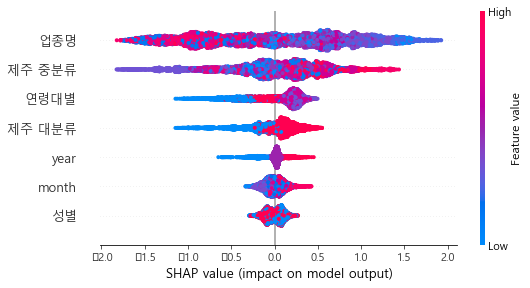

In [46]:
shap.summary_plot(shap_values_train, X_train)

**제주 중분류-업종명**
   1. 남원읍
      - 기타음료식품, 농축수산품은 남원읍에 긍정적인 영향을 끼쳤고 나머지는 부정적인 영향을 끼쳤다.
   2. 노형동
      - 슈퍼마켓, 스넥, 스포츠레져용품, 약국, 의원, 정장(여성)이 노형동에 긍정적인 영향을 끼쳤고, 기념품점, 기타음료식품,
        농축수산품은 부정적인 영향을 끼쳤다.
   3. 대륜동
      - 대륜동에 긍정적인 영향을 끼치는 요소는 농축수산품이다.
      - 농축수산품을 제외한 나머지는 모두 부정적인 영향을 끼친다.
      - 슈퍼마켓, 스넥이 대륜동에 가장 부정적인 영향을 끼쳤다.
   4. 삼도 2동
      - 슈퍼마켓, 스넥, 스포츠레저용품이 가장 부정적인 영향을 끼친다.
      - 나머지 항목들도 모두 부정적인 영향을 끼쳤다.
   5. 성산읍
      - 슈퍼마켓, 농축수산품, 기타음료식품, 기념품점이 긍정적인 영향을 끼치고 나머지는 부정적인 영향을 끼친다.
   6. 애월읍
      - 스넥, 슈퍼마켓이 애월읍에 긍정적인 영향을 끼쳤다.
      - 약국, 의원, 정장은 매우 부정적인 영향을 끼쳤다.
   7. 연동
      - 스포츠레저용품, 약국이 가장 큰 긍정적인 영향을 끼쳤으며 뒤이어 슈퍼마켓, 의원, 정장이 긍정적인 영향을 끼쳤다.
      - 기념품점, 기타음료식품, 농축수산품의 경우 긍정, 부정에 큰 영향을 끼치지 못하였다.
   8. 예래동
      - 슈퍼마켓, 기념품점의 경우 매우 부정적인 영향을 끼친다.
      - 나머지는 긍정적인 영향을 끼치긴 하지만 영향폭이 크지 않다.
   9. 용담 2동
      - 기념품점, 기타음료식품, 농축수산품의 경우 매우 긍정적인 영향을 끼쳤다.
      - 스넥, 스포츠레저용품, 약국의 경우 부정적인 영향을 끼쳤다.
   10. 이도 2동 
      - 농축수산품, 슈퍼마켓이 매우 긍정적인 영향을 끼쳤다. 그리고 의원, 약국, 기타음료식품이 뒤를 잇는다.
      - 전업종이 긍정적인 영향을 끼쳤다.
**성별-연령대별**
   1. 남자
      - 40,50대의 경우 긍정적인 영향을 끼친다.
      - 20,30대의 경우 부정적인 영향을 끼친다.
   2. 여자
      - 20,30대의 경우 긍정적인 영향을 끼친다.
      - 40,50대의 경우 부정적인 영향을 끼친다.
**연령대별-성별**
   1. 20대
      - 둘 다 부정적인 영향을 끼치지만 남성이 훨씬 부정적인 영향을 끼친다.
   2. 30대 
      - 둘 다 긍정적인 영향을 끼치지만 여성이 좀 더 긍정적인 영향을 끼친다.
   3. 40대 
      - 둘 다 긍정적인 영향을 끼치지만 남성이 좀 더 긍정적인 영향을 끼친다.
   4. 50대 
      - 전반적으로 남성은 긍정적인 영향을 끼치고 여성은 부정적인 영향을 끼친다.
**업종명-연령대별**
   1. 기념품점
      - 50대가 부정적인 영향을 끼친다.
   2. 기타음료식품
      - 모든 연령대가 부정적인 영향을 끼친다.
   3. 농축수산품
      - 50대가 가장 긍정적인 영향을 끼친다.
      - 모든 연령대가 긍정적인 영향을 끼친다.
   4. 슈퍼마켓
      - 전 연령이 긍정적인 영향을 끼치지만 특히 50대가 높은 영향을 끼친다.
   5. 스넥 
      - 20,30,40,50대는 부정, 긍정 영향이 비슷하지만 50대는 대다수가 부정적인 영향을 끼친다.
   6. 스포츠레저용품
      - 50대를 제외한 나머지 연령대들의 긍정, 부정의 영향이 비슷하다.
   7. 약국, 의원, 정장(여성)
      - 모두 전연령대 부정적 영향을 끼친다.
      
      

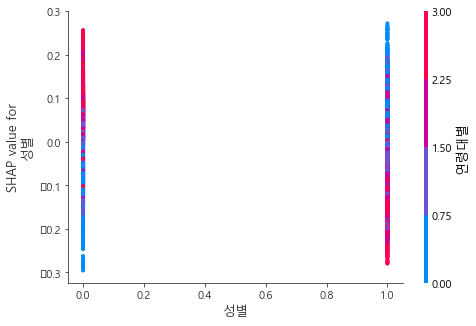

In [47]:
shap.dependence_plot("성별",shap_values_train ,X_train,interaction_index="연령대별")

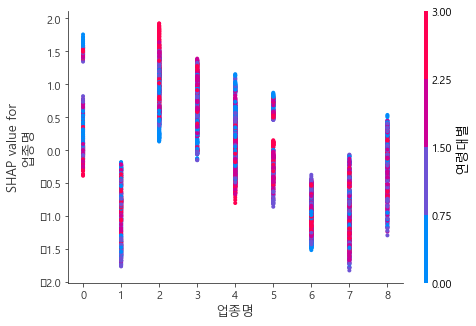

In [48]:
shap.dependence_plot("업종명",shap_values_train ,X_train,interaction_index="연령대별")

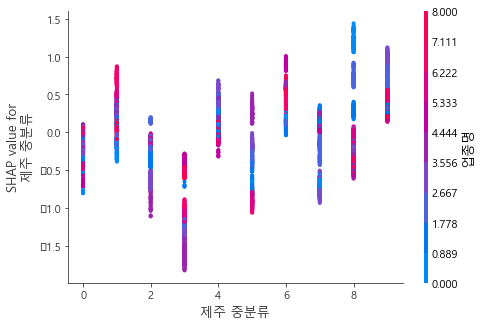

In [49]:
shap.dependence_plot("제주 중분류",shap_values_train ,X_train,interaction_index="업종명")

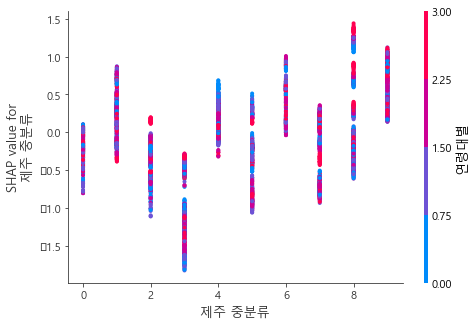

In [50]:
shap.dependence_plot("제주 중분류",shap_values_train ,X_train,interaction_index="연령대별")

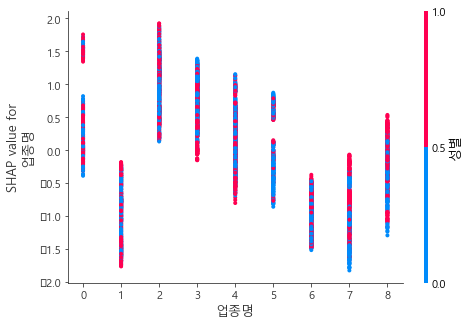

In [51]:
shap.dependence_plot("업종명",shap_values_train ,X_train,interaction_index="성별")

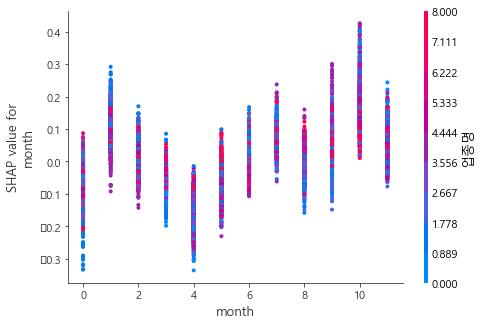

In [52]:
shap.dependence_plot("month",shap_values_train ,X_train,interaction_index="업종명")

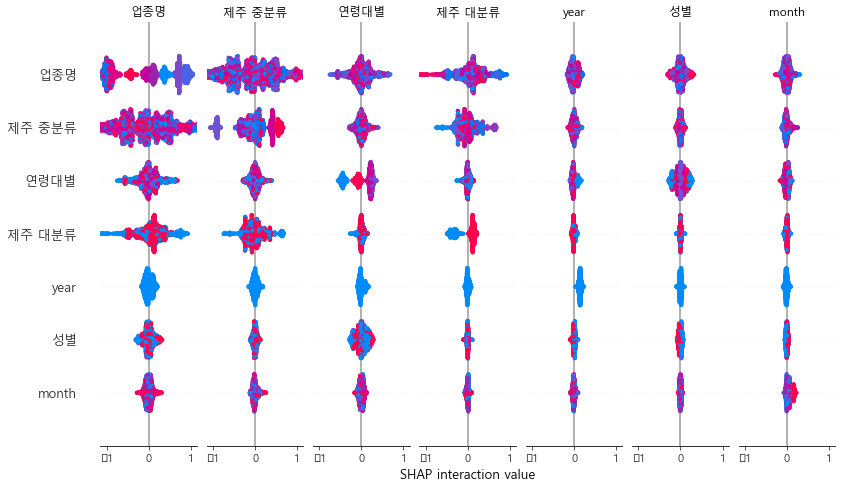

In [53]:
shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:,:])
shap.summary_plot(shap_interaction_values, X_test.iloc[:,:])

- model의 예측에 절대적으로 영향을 끼치는 feature들을 순서대로 나타낸것이다.
- 업종명이 가장 큰 영향을 끼치며 이후로 제주 중분류, 연령대별, 제주 대분류, year, 성별, month가 뒤를 잇는다.

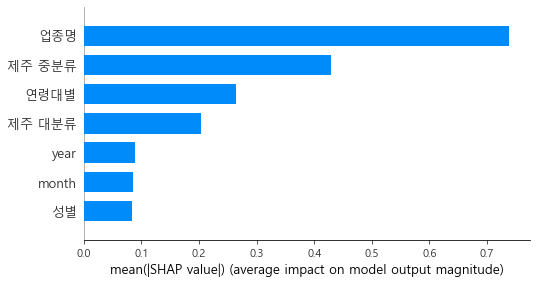

In [55]:
# 각 변수의 shap value에 절대값을 취한 것으로 변수의 평균적인 영향력을 보여준다.
# 큰 영향력을 보일수록, target과 관계성이 크다는 것이다.
shap.summary_plot(shap_values_train, X_train, plot_type="bar")

#### LightGBM-GridSearchCV를 이용한 최적의 parameter 찾기
- GridSearchCV를 이용하여 최적의 parameter를 찾아보았지만 오히려 성능이 떨어지는 현상이 생김

In [56]:
grid_params={
              'n_estimators':[130,140,150],
              'min_child_samples':[10,20],
              'learning_rate':[0.2,0.25,0.3],
              'num_leaves': [30,40],
}

In [57]:
from sklearn.model_selection import GridSearchCV

dtrain = lgbm.Dataset(X_train,y_train_log)
dtest = lgbm.Dataset(X_test,np.log1p(y_test))

grid_lgbm = GridSearchCV(lgbm.LGBMRegressor(),param_grid=grid_params,cv=5,refit=True)
grid_lgbm.fit(X_train,y_train_log)


print('GridSearchCV 최적 파라미터:',grid_lgbm.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_lgbm.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.2, 'min_child_samples': 10, 'n_estimators': 130, 'num_leaves': 40}
GridSearchCV 최고 정확도:0.8676


#### Parameter 최적화

In [58]:
# Light GBM 모델에 쓰일 parameter 정의하기
# 위의 GridSearchCV 결과를 가지고 다시 parameter를 조정하여 Model 실행.
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993  
lgbm_param = {'n_estimators':140,
              'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,
              'min_child_samples':10,
              'learning_rate':0.3,
              'tree_learner': 'serial',
              'early_stopping_rounds':100,
              'subsample_freq': 1,
              'colsample_bytree':1,
              'num_leaves': 30,
              'verbose':-1,
              'seed' : SEED
            }

In [59]:
lgbm_oof_train = np.zeros((local_train.shape[0],))
lgbm_oof_test = np.zeros((local_test.shape[0],))

cv_list=[]

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# target variable에 log변환을 취해준다.
y_train_log = np.log1p(y_train)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train_log ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train.iloc[trn_ind], y_train_log[trn_ind]
    X_valid , y_valid = X_train.iloc[val_ind], y_train_log[val_ind]
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train_f, y_train_f)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    lgbm_model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','test'), 
                       verbose_eval= 30)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = lgbm_model.predict(X_valid)
    lgbm_test_pred = lgbm_model.predict(X_test)    
    
    cv_list.append(sqrt(mean_squared_error(y_valid,lgbm_valid_pred)))
    
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/n_splits
    
    print('='*80)
    
print(f"<LOCAL_TRAIN> OVERALL RMSE : {sqrt( mean_squared_error( y_train_log, lgbm_oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {sqrt( mean_squared_error( np.log1p(y_test), lgbm_oof_test ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 100 rounds
[30]	train's rmse: 0.416475	test's rmse: 0.432319
[60]	train's rmse: 0.353241	test's rmse: 0.394254
[90]	train's rmse: 0.319585	test's rmse: 0.380354
[120]	train's rmse: 0.299187	test's rmse: 0.375141
Did not meet early stopping. Best iteration is:
[140]	train's rmse: 0.288186	test's rmse: 0.371497
---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
Training until validation scores don't improve for 100 rounds
[30]	train's rmse: 0.410316	test's rmse: 0.426935
[60]	train's rmse: 0.35236	test's rmse: 0.394812
[90]	train's rmse: 0.321444	test's rmse: 0.382551
[120]	train's rmse: 0.301049	test's rmse: 0.375702
Did not meet early stopping. Best iteration is:
[140]	train's rmse: 0.290516	test's rmse: 0.374251
---TRAINING LIGHT GBM---
[LightGBM] [Warning] seed is set=1993, random_state=1993 will be ignored. Current value: seed=1993
Trai

### XGBoost

In [61]:
xgb_oof_train = np.zeros((local_train.shape[0],))
xgb_oof_test = np.zeros((local_test.shape[0],))

cv_list=[]

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# target variable에 log변환을 취해준다.
y_train_log = np.log1p(y_train)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train_log ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train.iloc[trn_ind], y_train_log[trn_ind]
    X_valid , y_valid = X_train.iloc[val_ind], y_train_log[val_ind]
    # (6) XGBoost
    print("---TRAINING XGBOOST--")
    dtrain = xgb.DMatrix(X_train_f,y_train_f)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    # model 정의 & 학습
    xgb_model = xgb.train(xgb_params,dtrain, NUM_BOOST_ROUND,
                     evals=[(dtrain,'train'),(dvalid,'valid')],
                        early_stopping_rounds=100,
                         verbose_eval=30)
    
    xgb_valid_pred = xgb_model.predict(dvalid)
    xgb_test_pred = xgb_model.predict(xgb.DMatrix(X_test,np.log1p(y_test)))    
    
    cv_list.append(sqrt(mean_squared_error(y_valid,xgb_valid_pred)))
    
    xgb_oof_train[val_ind] = xgb_valid_pred
    xgb_oof_test += xgb_test_pred/n_splits
    print('='*80)

print(f"<LOCAL_TRAIN> OVERALL RMSE : {sqrt( mean_squared_error( y_train_log, xgb_oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {sqrt( mean_squared_error( np.log1p(y_test), xgb_oof_test ) )}")

0it [00:00, ?it/s]

---TRAINING XGBOOST--
[0]	train-rmse:9.71866	valid-rmse:9.69676
[30]	train-rmse:0.38515	valid-rmse:0.41147
[60]	train-rmse:0.32027	valid-rmse:0.37932
[90]	train-rmse:0.29241	valid-rmse:0.37537
[120]	train-rmse:0.27185	valid-rmse:0.37501
[150]	train-rmse:0.25778	valid-rmse:0.37634
[180]	train-rmse:0.24546	valid-rmse:0.37617
[210]	train-rmse:0.23622	valid-rmse:0.37798
[218]	train-rmse:0.23398	valid-rmse:0.37911
---TRAINING XGBOOST--
[0]	train-rmse:9.71211	valid-rmse:9.72835
[30]	train-rmse:0.38520	valid-rmse:0.40981
[60]	train-rmse:0.32162	valid-rmse:0.37478
[90]	train-rmse:0.29047	valid-rmse:0.36802
[120]	train-rmse:0.27333	valid-rmse:0.36781
[150]	train-rmse:0.25899	valid-rmse:0.36855
[180]	train-rmse:0.24764	valid-rmse:0.36968
[197]	train-rmse:0.24211	valid-rmse:0.37037
---TRAINING XGBOOST--
[0]	train-rmse:9.70919	valid-rmse:9.72989
[30]	train-rmse:0.38222	valid-rmse:0.44609
[60]	train-rmse:0.31737	valid-rmse:0.41162
[90]	train-rmse:0.28746	valid-rmse:0.40329
[120]	train-rmse:0.26878	

#### XGBoost-GridSearchCV를 이용한 최적의 parameter 찾기
- XGBoost 또한 GridSearchCV를 이용해 찾은 parameter가 오히려 더 안좋은 결과를 도출한다.

In [62]:
grid_params={
              'num_boost_rounds':[130,140,150],
              'min_child_weight':[0.5,1,2],
              'eta':[0.2,0.25,0.3],
              'max_depth':[4,5,6,7],
}

In [63]:
from sklearn.model_selection import GridSearchCV

# dtrain = xgb.Dataset(X_train,y_train_log)
# dtest = xgb.Dataset(X_test,np.log1p(y_test))

grid_xgb = GridSearchCV(xgb.XGBRegressor(silent=1,verbosity=0),param_grid=grid_params,cv=5,refit=True)
grid_xgb.fit(X_train,y_train_log)

print('GridSearchCV 최적 파라미터:',grid_xgb.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_xgb.best_score_))

GridSearchCV 최적 파라미터: {'eta': 0.2, 'max_depth': 6, 'min_child_weight': 0.5, 'num_boost_rounds': 130}
GridSearchCV 최고 정확도:0.8597


In [64]:
# XGBoost 모델에 쓰일 parameter 정의
xgb_params={ 'booster':'gbtree',
         'verbosity':0,
         'silent':1,
         'num_boost_rounds':130,
         'min_child_weight':0.5,
         'max_depth':6,
         'early_stopping_rounds':50,
         'eta':0.2,
         'sub_sample':0.5,
         'eval_metric':'rmse',
}

In [66]:
xgb_oof_train = np.zeros((local_train.shape[0],))
xgb_oof_test = np.zeros((local_test.shape[0],))

cv_list=[]

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# target variable에 log변환을 취해준다.
y_train_log = np.log1p(y_train)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train_log ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train.iloc[trn_ind], y_train_log[trn_ind]
    X_valid , y_valid = X_train.iloc[val_ind], y_train_log[val_ind]
    # (6) XGBoost
    print("---TRAINING XGBOOST--")
    dtrain = xgb.DMatrix(X_train_f,y_train_f)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    # model 정의 & 학습
    xgb_model = xgb.train(xgb_params,dtrain, NUM_BOOST_ROUND,
                     evals=[(dtrain,'train'),(dvalid,'valid')],
                        early_stopping_rounds=100,
                         verbose_eval=30)
    
    xgb_valid_pred = xgb_model.predict(dvalid)
    xgb_test_pred = xgb_model.predict(xgb.DMatrix(X_test,np.log1p(y_test)))    
    
    cv_list.append(sqrt(mean_squared_error(y_valid,xgb_valid_pred)))
    
    xgb_oof_train[val_ind] = xgb_valid_pred
    xgb_oof_test += xgb_test_pred/n_splits
    print('='*80)

print(f"<LOCAL_TRAIN> OVERALL RMSE : {sqrt( mean_squared_error( y_train_log, xgb_oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {sqrt( mean_squared_error( np.log1p(y_test), xgb_oof_test ) )}")

0it [00:00, ?it/s]

---TRAINING XGBOOST--
[0]	train-rmse:11.09159	valid-rmse:11.06641
[30]	train-rmse:0.44320	valid-rmse:0.45948
[60]	train-rmse:0.35395	valid-rmse:0.39664
[90]	train-rmse:0.31931	valid-rmse:0.38131
[120]	train-rmse:0.29752	valid-rmse:0.37618
[150]	train-rmse:0.28308	valid-rmse:0.37425
[180]	train-rmse:0.27089	valid-rmse:0.37527
[210]	train-rmse:0.26104	valid-rmse:0.37633
[240]	train-rmse:0.25308	valid-rmse:0.37780
[248]	train-rmse:0.25113	valid-rmse:0.37789
---TRAINING XGBOOST--
[0]	train-rmse:11.08427	valid-rmse:11.09949
[30]	train-rmse:0.43884	valid-rmse:0.45839
[60]	train-rmse:0.35573	valid-rmse:0.39348
[90]	train-rmse:0.32361	valid-rmse:0.37777
[120]	train-rmse:0.30321	valid-rmse:0.37164
[150]	train-rmse:0.28776	valid-rmse:0.37023
[180]	train-rmse:0.27521	valid-rmse:0.36960
[210]	train-rmse:0.26452	valid-rmse:0.36791
[240]	train-rmse:0.25581	valid-rmse:0.36900
[270]	train-rmse:0.24813	valid-rmse:0.36960
[300]	train-rmse:0.24138	valid-rmse:0.36982
[310]	train-rmse:0.23945	valid-rmse:0.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

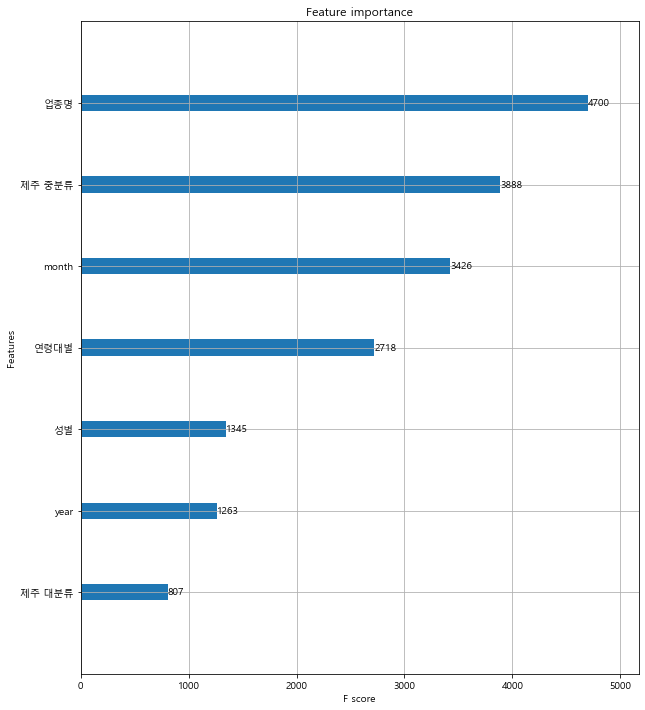

In [67]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgb_model, ax=ax)

### Ensemble

In [69]:
ensemble_pred = 0.5*(xgb_oof_test+lgbm_oof_test)
sample_submission['카드이용금액'] = np.clip(ensemble_pred,0,max(ensemble_pred))

NameError: name 'sample_submission' is not defined

## 4. 결론